In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
import numpy as np
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
exp5_1_df = pd.read_csv('./csv/exp5_1.csv', sep=',')

In [3]:
exp5_2_df = pd.read_csv('./csv/exp5_2.csv', sep=',')

In [4]:
exp5_3_df = pd.read_csv('./csv/exp5_3.csv', sep=',')

In [5]:
exp5_weight_df = pd.read_csv('./csv/exp5_weight.csv', sep=';')

Данные измерений на весах

In [6]:
exp5_weight_df

measurement  weight
0             1     219
1             2     716
2             3    1084
3             4     599
4             5    1799
5             6    4268
6             7    4859
7             8     716
8             9    1365
9            10    1800
10           11    2448
11           12    3140
12           13    1409
13           14     605
14           15    2013
15           16    2491
16           17    2123
17           18    3162
18           19    3528
19           20    4235

Объединим все измерения тензодатчика

In [7]:
dataframes = [exp5_1_df, exp5_2_df, exp5_3_df]

In [8]:
exp5_all = pd.concat([df for df in dataframes], axis=0)

In [9]:
exp5_all.dtypes

Timestamp              object
Relative_Time         float64
TYAGA_raw               int64
Valve_KNOPKA_state      int64
dtype: object

Преобразуем в формат времени 'Timestamp'

In [10]:
exp5_all['Timestamp'] = pd.to_datetime(exp5_all['Timestamp'])

In [11]:
exp5_all.dtypes

Timestamp             datetime64[ns]
Relative_Time                float64
TYAGA_raw                      int64
Valve_KNOPKA_state             int64
dtype: object

Фунция для отображения графика TYAGA_raw и Valve_KNOPKA_state по времени

In [12]:
def fig_TYAGA_Valve_KNOPKA_state(df):
    # Создание фигуры и оси
    fig, ax1 = plt.subplots(figsize=(18, 6))
    
    # Построение графика для 'TYAGA_raw'
    ax1.plot(df['Timestamp'], df['TYAGA_raw'], color='tab:blue')
    ax1.set_xlabel('Timestamp')
    ax1.set_ylabel('TYAGA_raw', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    
    # Создание второй оси y
    ax2 = ax1.twinx()
    ax2.plot(df['Timestamp'], df['Valve_KNOPKA_state'], color='tab:red')
    ax2.set_ylabel('Valve_KNOPKA_state', color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')
    
    # Опционально: форматирование и улучшение внешнего вида графика 
    plt.title('График TYAGA_raw и Valve_KNOPKA_state по времени')
    fig.tight_layout()  # Чтобы графики не перекрывались
    
    # Отображение графика
    plt.show()

Посмотрим на сырые данные

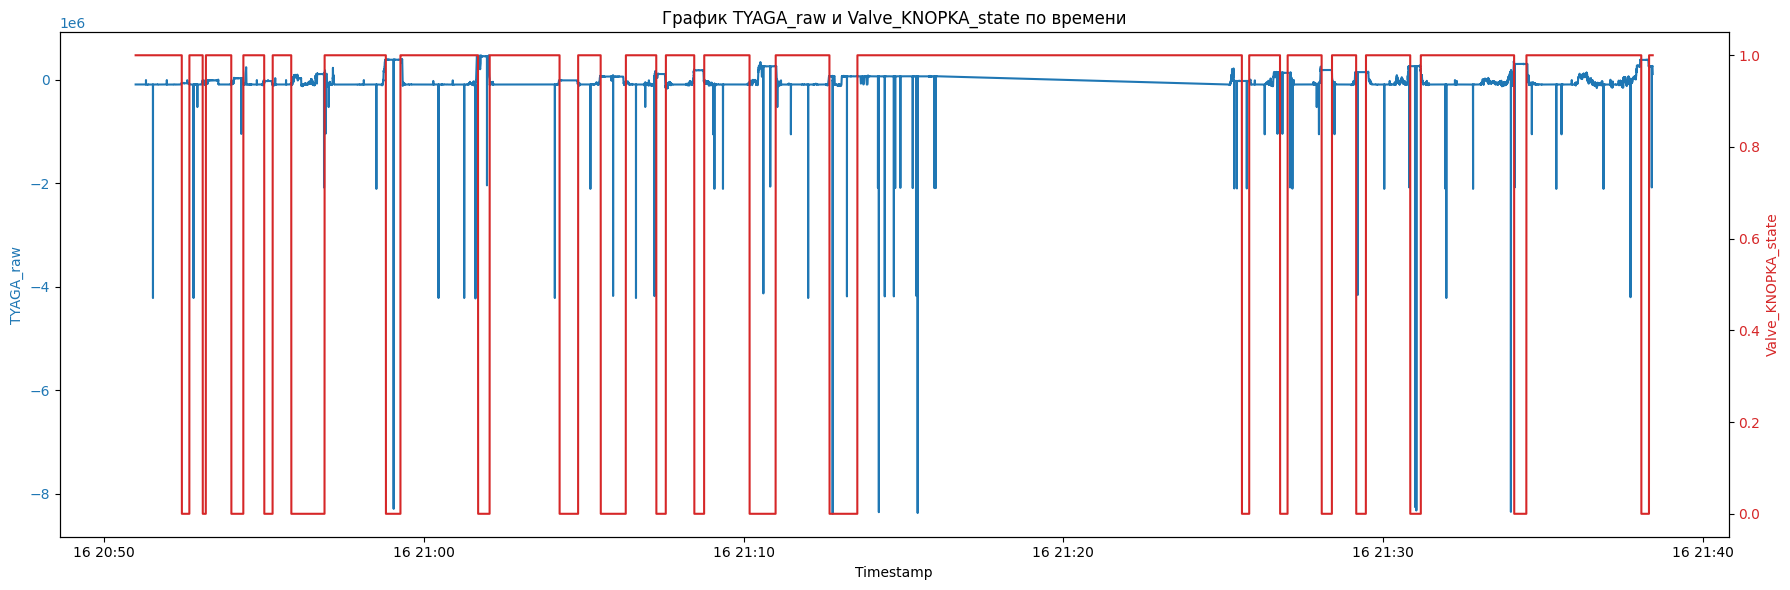

In [13]:
fig_TYAGA_Valve_KNOPKA_state(exp5_all)

Из графика видно, что в данных имеются выбросы. Удалим значения, которые меньше -100000

In [14]:
exp5_all = exp5_all[exp5_all['TYAGA_raw'] > -100000]

Посмотрим на данные после удаления выбросов

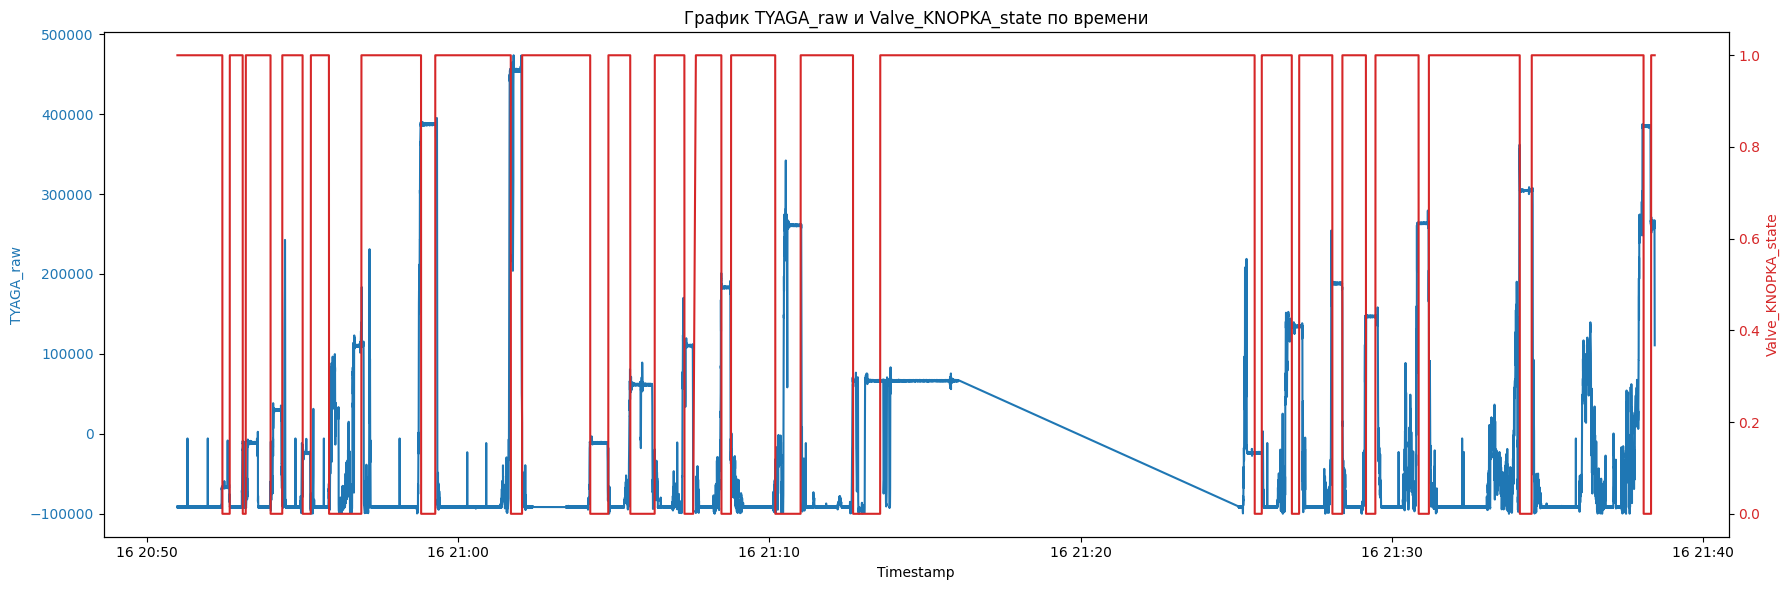

In [15]:
fig_TYAGA_Valve_KNOPKA_state(exp5_all)

Вычисление изменений состояний

In [16]:
exp5_all.loc[:, 'change_detected'] = exp5_all['Valve_KNOPKA_state'].diff().fillna(0) != 0

In [17]:
exp5_all

Timestamp  Relative_Time  TYAGA_raw  Valve_KNOPKA_state  \
0    2025-01-16 20:50:58.842         19.657     -90780                   1   
1    2025-01-16 20:50:58.843         19.658     -90780                   1   
2    2025-01-16 20:50:58.843         19.658     -92156                   1   
3    2025-01-16 20:50:58.843         19.658     -92156                   1   
4    2025-01-16 20:50:58.952         19.767     -90983                   1   
...                      ...            ...        ...                 ...   
8605 2025-01-16 21:38:26.076        821.202     267241                   1   
8606 2025-01-16 21:38:26.184        821.310     224640                   1   
8607 2025-01-16 21:38:26.305        821.431     156482                   1   
8608 2025-01-16 21:38:26.407        821.534     117797                   1   
8609 2025-01-16 21:38:26.524        821.650     110787                   1   

      change_detected  
0               False  
1               False  
2               False  
3               False  
4               False  
...               ...  
8605            False  
8606            False  
8607            False  
8608            False  
8609            False  

[23447 rows x 5 columns]

Накопительный счет изменений состояний

In [18]:
exp5_all.loc[:, 'cumulative_changes'] = exp5_all['change_detected'].cumsum()

Отфильтруем значения, которые резко отличаются  от соседних и значения, соответсвующие отсутствию груза

In [19]:
# Рассчитаем абсолютную разницу между соседними значениями
exp5_all['diff'] = exp5_all['TYAGA_raw'].diff().abs()

# Оставим строки, где разница менее порогового значения
exp5_all_filtered = exp5_all[(exp5_all['diff'] <= 1000)&(exp5_all['TYAGA_raw'] > -80000)]

# Сбросим индексы для удобства
exp5_all_filtered = exp5_all_filtered.reset_index(drop=True)

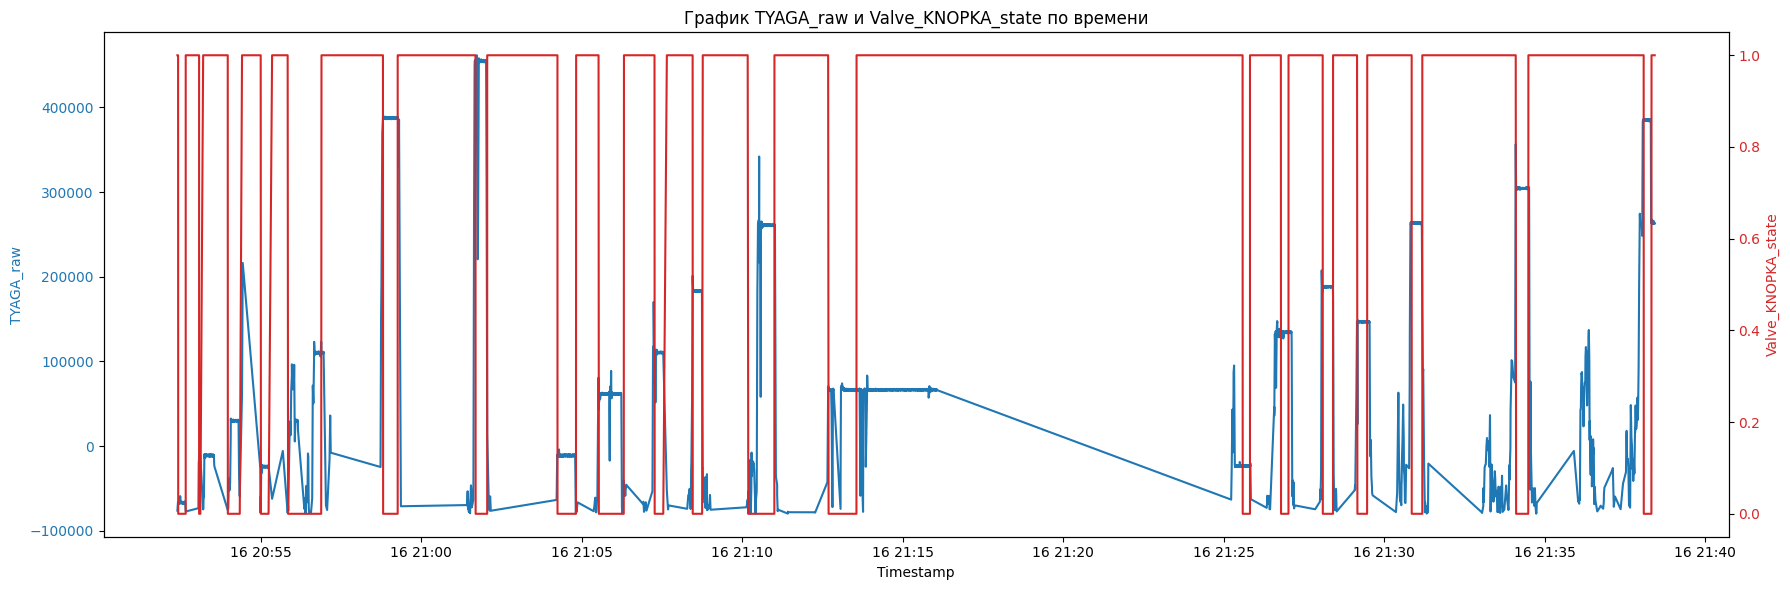

In [20]:
fig_TYAGA_Valve_KNOPKA_state(exp5_all_filtered)

In [21]:
def fig_TYAGA(df, measurement_number):
    # Рассчитаем среднее значение
    mean_taga = df['TYAGA_raw'].mean()

    # Создание фигуры и оси
    fig, ax1 = plt.subplots(figsize=(18, 6))
    
    # Построение графика для 'TYAGA_raw'
    ax1.plot(df['Timestamp'], df['TYAGA_raw'], color='tab:blue', label='TYAGA_raw')
    
    # Добавление линии среднего значения
    ax1.axhline(mean_taga, color='tab:red', linestyle='--', linewidth=2, label=f'Среднее значение TYAGA_raw = {mean_taga:.2f}')
    
    # Настройка меток и легенды
    ax1.set_xlabel('Timestamp')
    ax1.set_ylabel('TYAGA_raw', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.legend(loc='best')

    # Установка заголовка и отображение графика
    plt.title(f'График TYAGA_raw по времени, измерение {measurement_number}')
    fig.tight_layout()
    plt.savefig(f'./results/fig/measurement_{measurement_number}.png')
    plt.show()

    # Добавление среднего значения в exp5_weight_df
    exp5_weight_df.loc[exp5_weight_df['measurement'] == measurement_number, 'mean_TYAGA_raw'] = mean_taga

## Ищем время измерений визуально

1 взвешивание

In [22]:
df = exp5_all_filtered[(exp5_all_filtered['cumulative_changes']>=0)&(exp5_all_filtered['cumulative_changes']<2)]

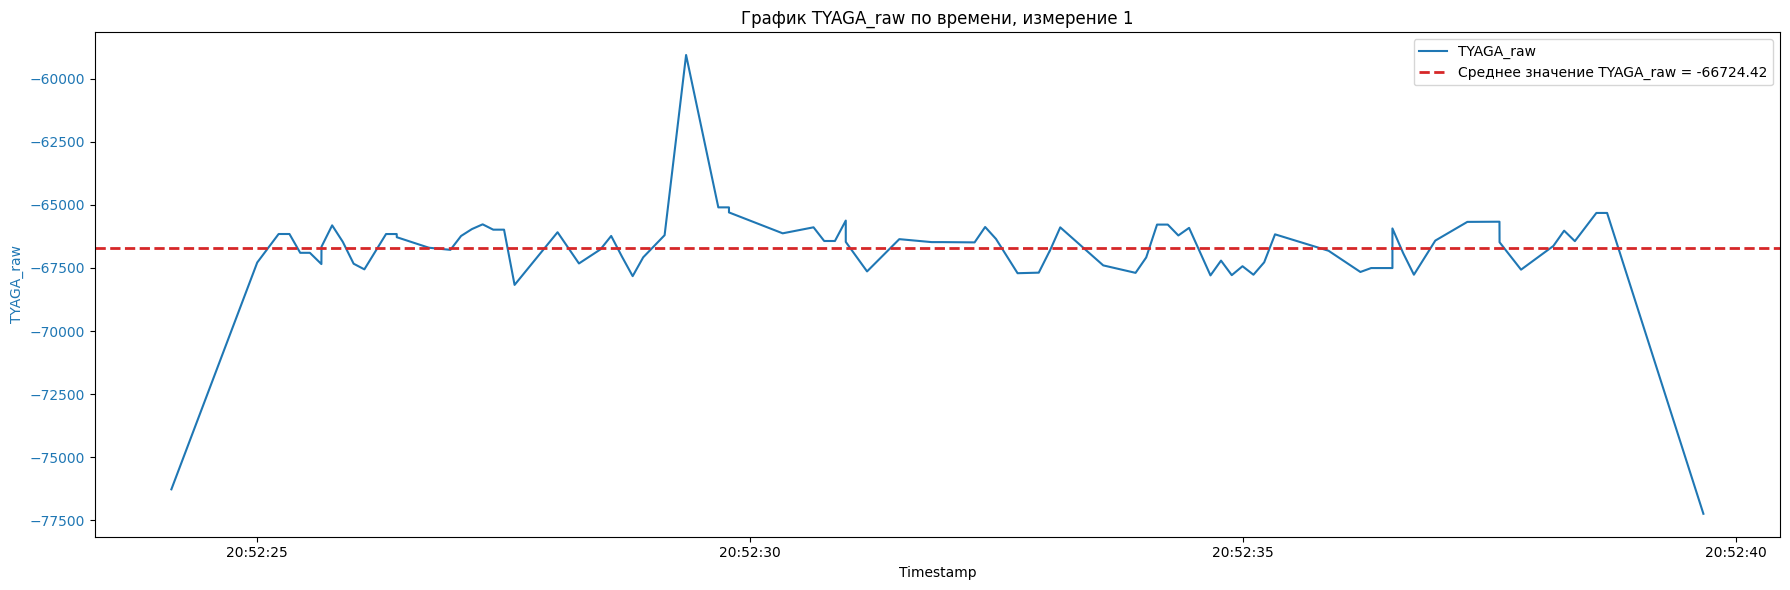

In [23]:
fig_TYAGA(df, 1)

2 взвешивание

In [24]:
df = exp5_all_filtered[(exp5_all_filtered['cumulative_changes']>=3)&(exp5_all_filtered['cumulative_changes']<5)]

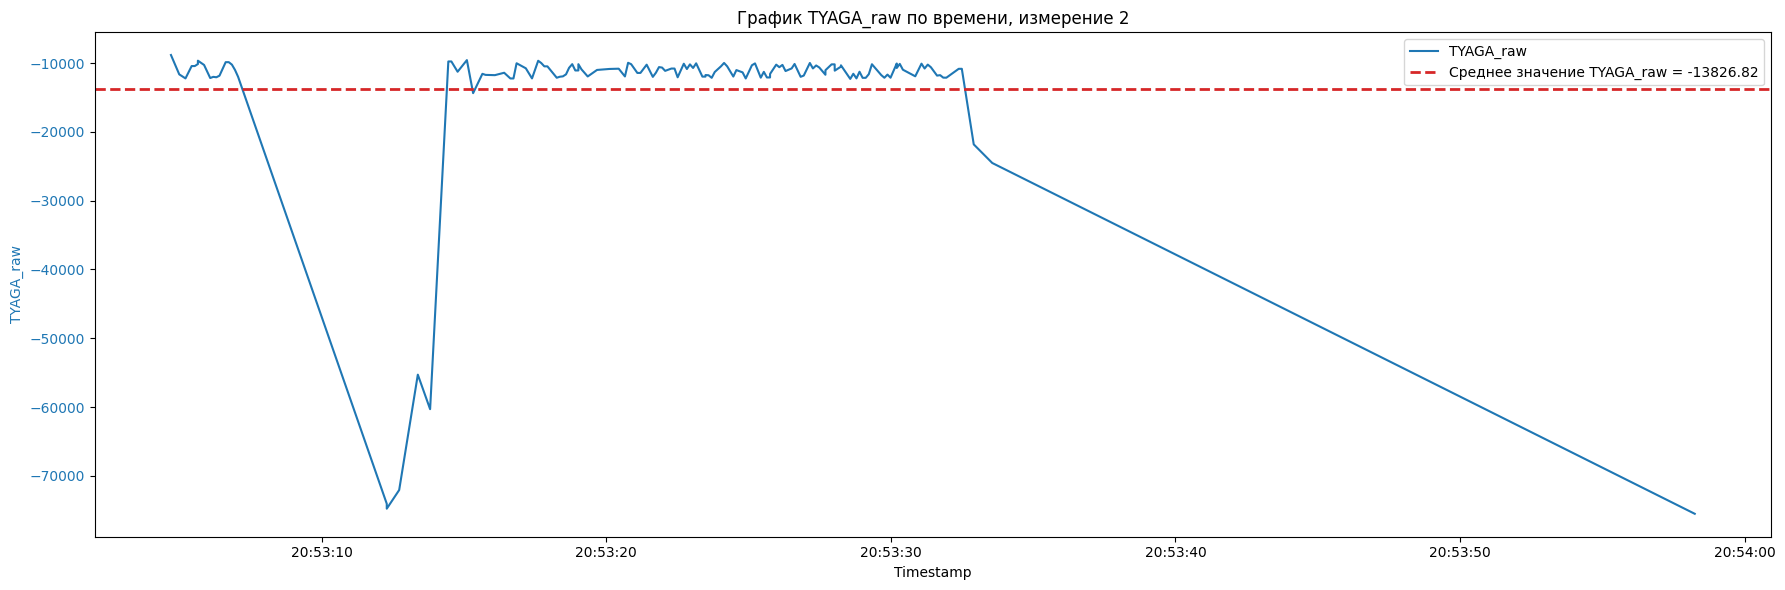

In [25]:
fig_TYAGA(df, 2)

3 взвешивание

In [26]:
df = exp5_all_filtered[(exp5_all_filtered['cumulative_changes']>=5)&(exp5_all_filtered['cumulative_changes']<7)]

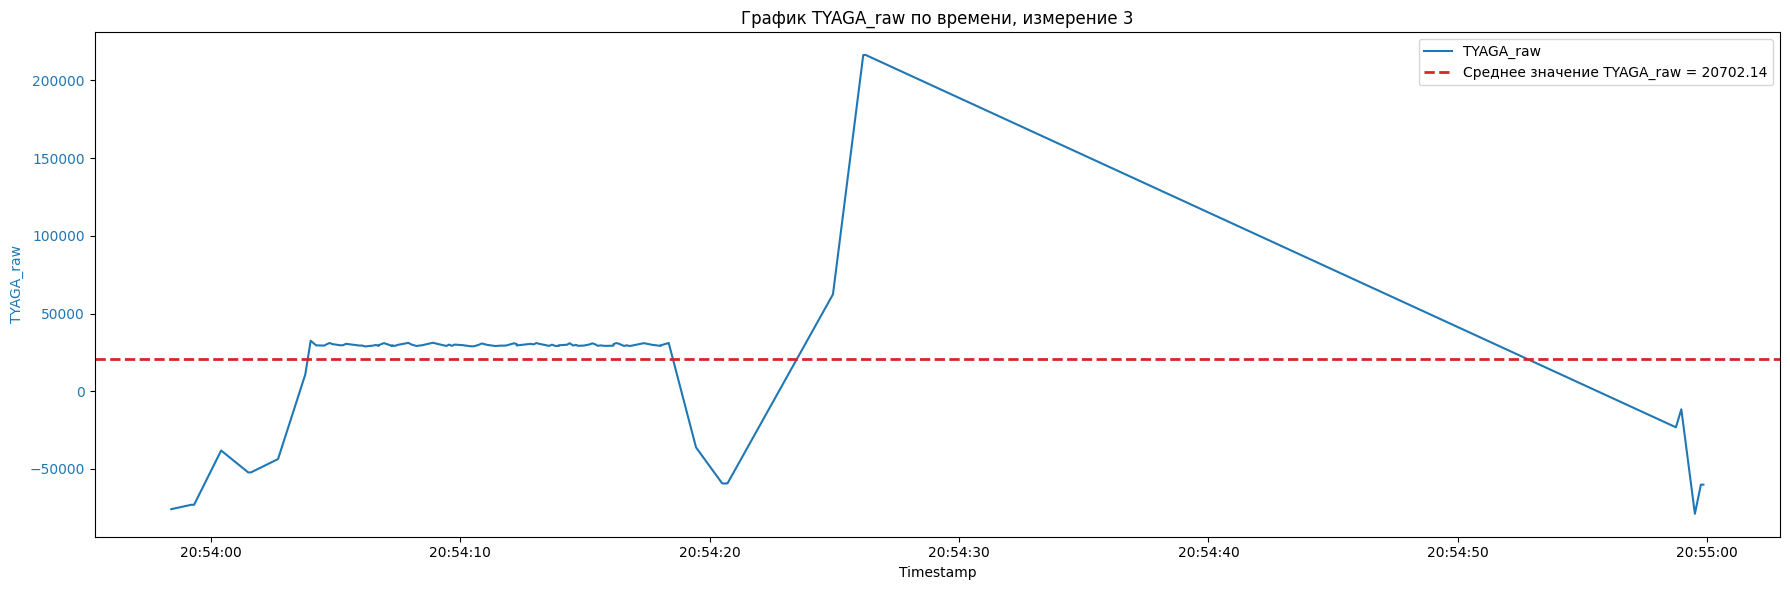

In [27]:
fig_TYAGA(df, 3)

4 взвешивание

In [28]:
df = exp5_all_filtered[(exp5_all_filtered['cumulative_changes']>=5)&(exp5_all_filtered['cumulative_changes']<6)]

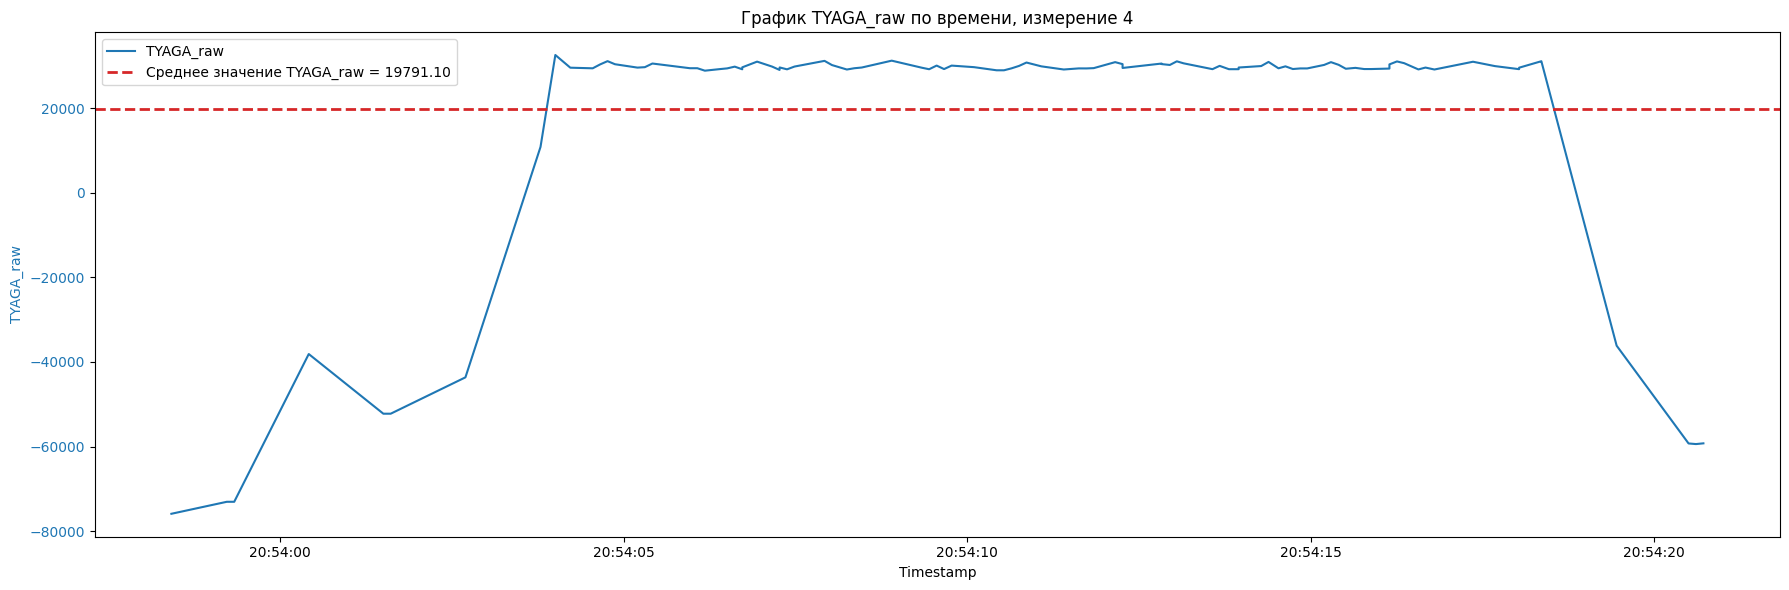

In [29]:
fig_TYAGA(df, 4)

5 взвешивание

In [30]:
df = exp5_all_filtered[(exp5_all_filtered['cumulative_changes']>=9)&(exp5_all_filtered['cumulative_changes']<10)]

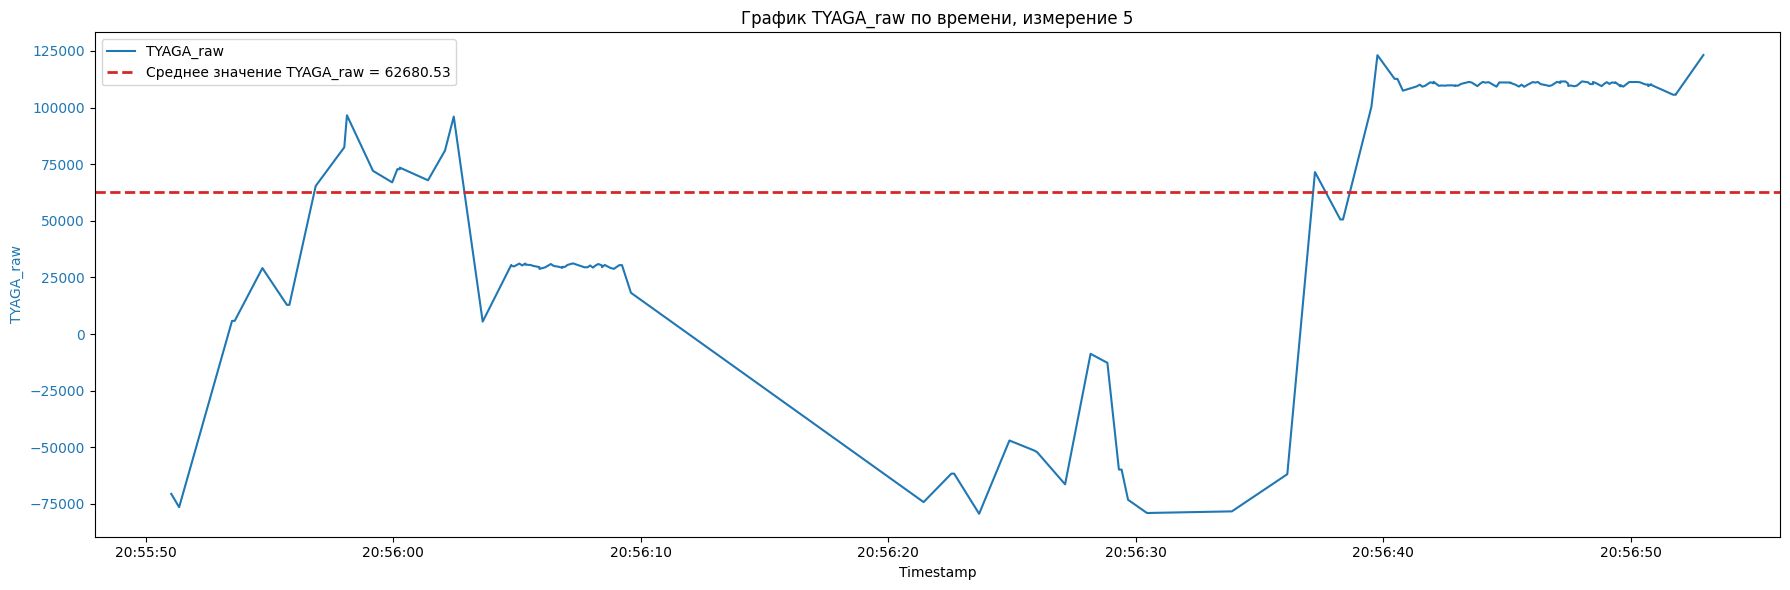

In [31]:
fig_TYAGA(df, 5)

6 взвешивание

In [32]:
df = exp5_all_filtered[(exp5_all_filtered['cumulative_changes']>=10)&(exp5_all_filtered['cumulative_changes']<12)]

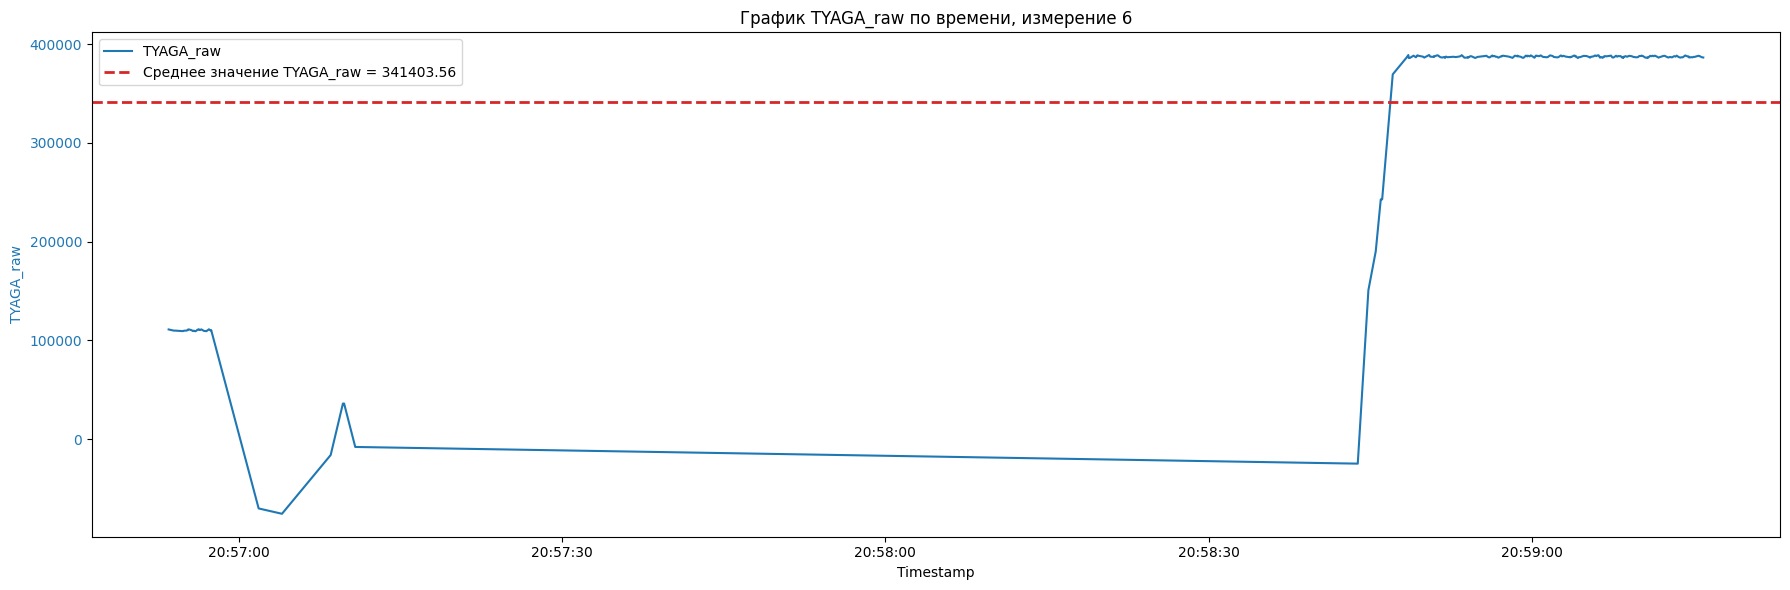

In [33]:
fig_TYAGA(df, 6)

7 взвешивание

In [34]:
df = exp5_all_filtered[(exp5_all_filtered['cumulative_changes']>=13)&(exp5_all_filtered['cumulative_changes']<14)]

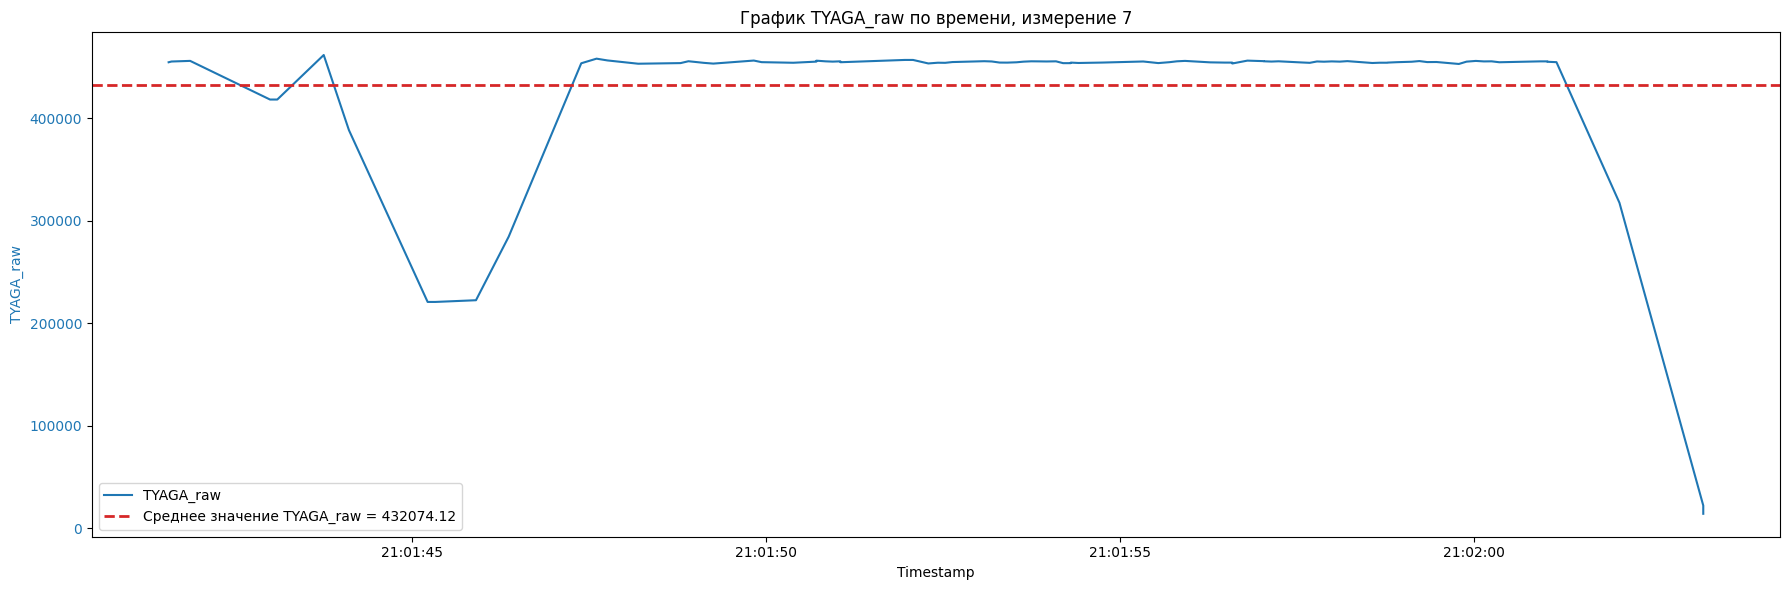

In [35]:
fig_TYAGA(df, 7)

8 взвешивание

In [36]:
df = exp5_all_filtered[(exp5_all_filtered['cumulative_changes']>=14)&(exp5_all_filtered['cumulative_changes']<16)]

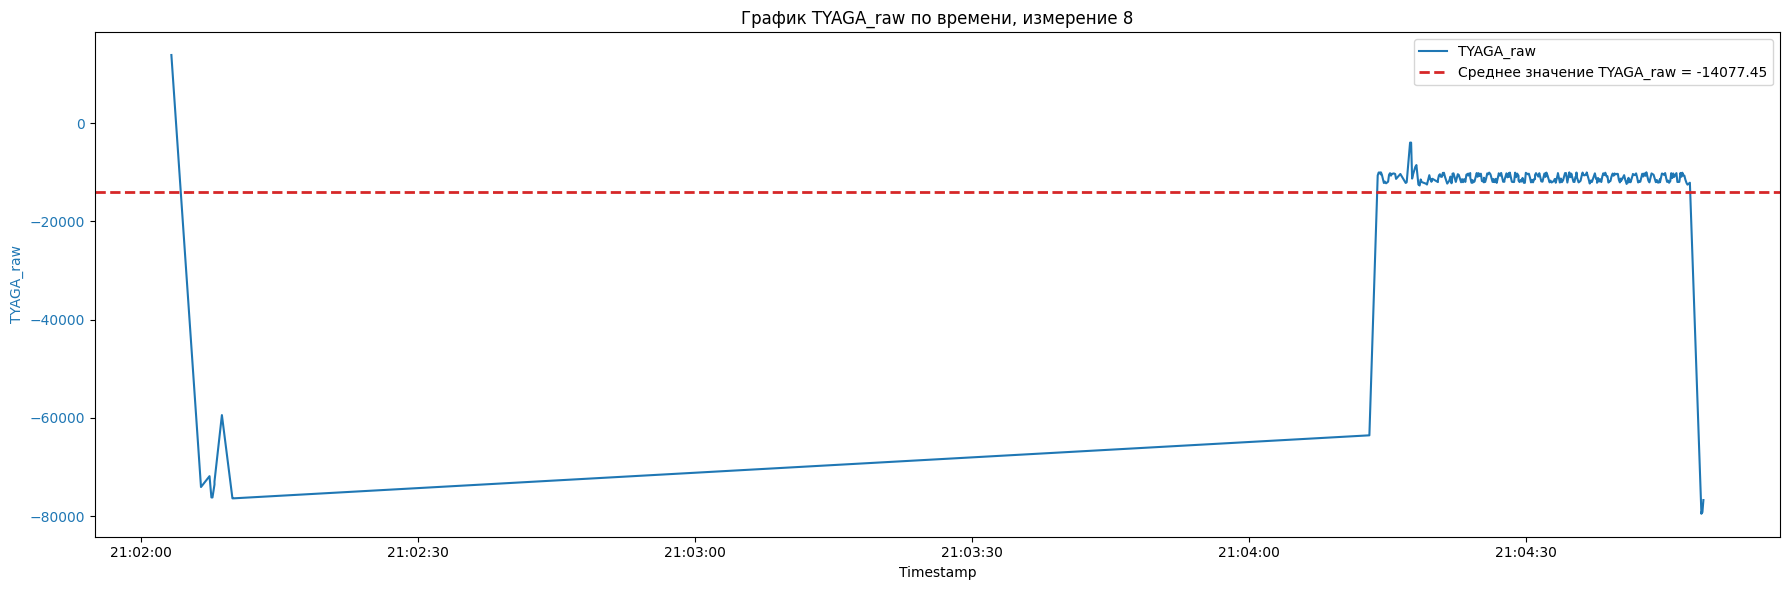

In [37]:
fig_TYAGA(df, 8)

9 взвешивание

In [38]:
df = exp5_all_filtered[(exp5_all_filtered['cumulative_changes']>=16)&(exp5_all_filtered['cumulative_changes']<18)]

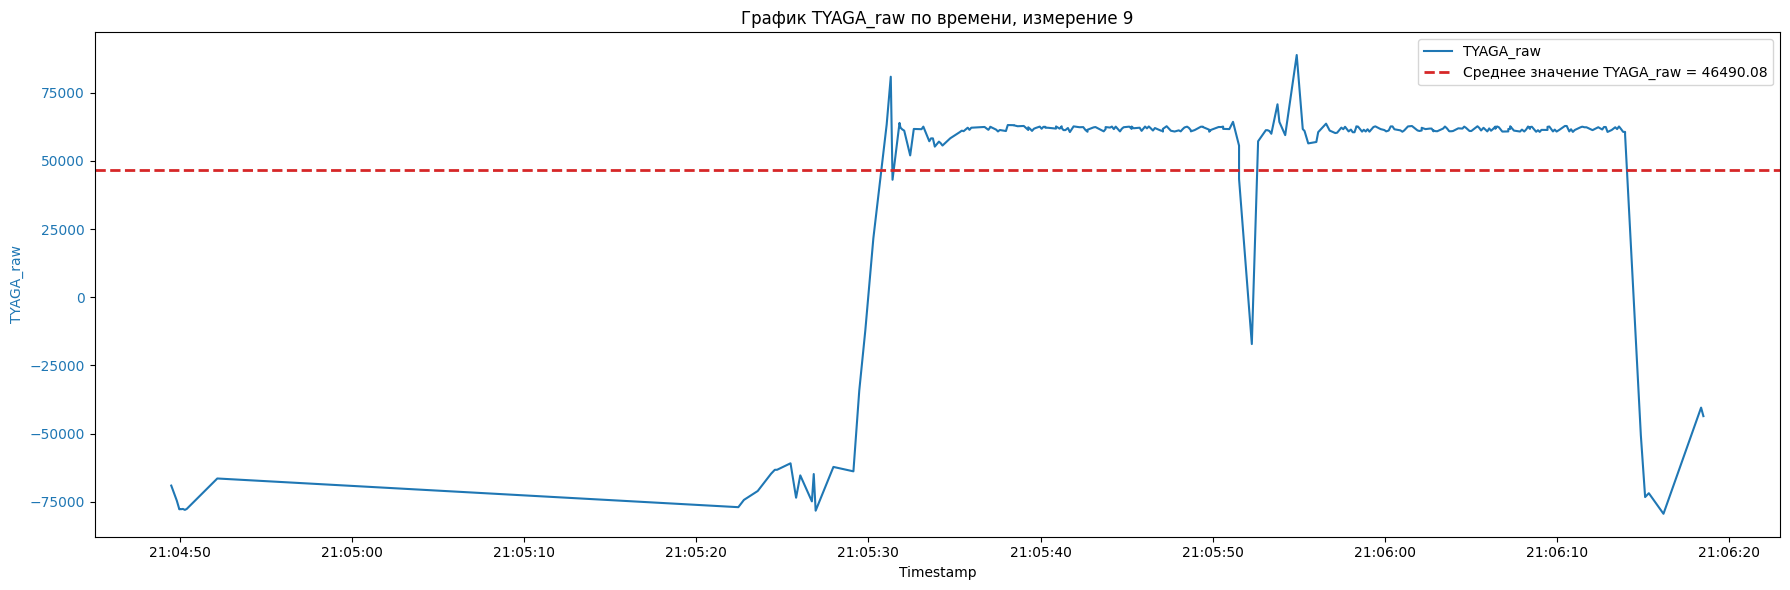

In [39]:
fig_TYAGA(df, 9)

10 взвешивание

In [40]:
df = exp5_all_filtered[(exp5_all_filtered['cumulative_changes']>=18)&(exp5_all_filtered['cumulative_changes']<20)]

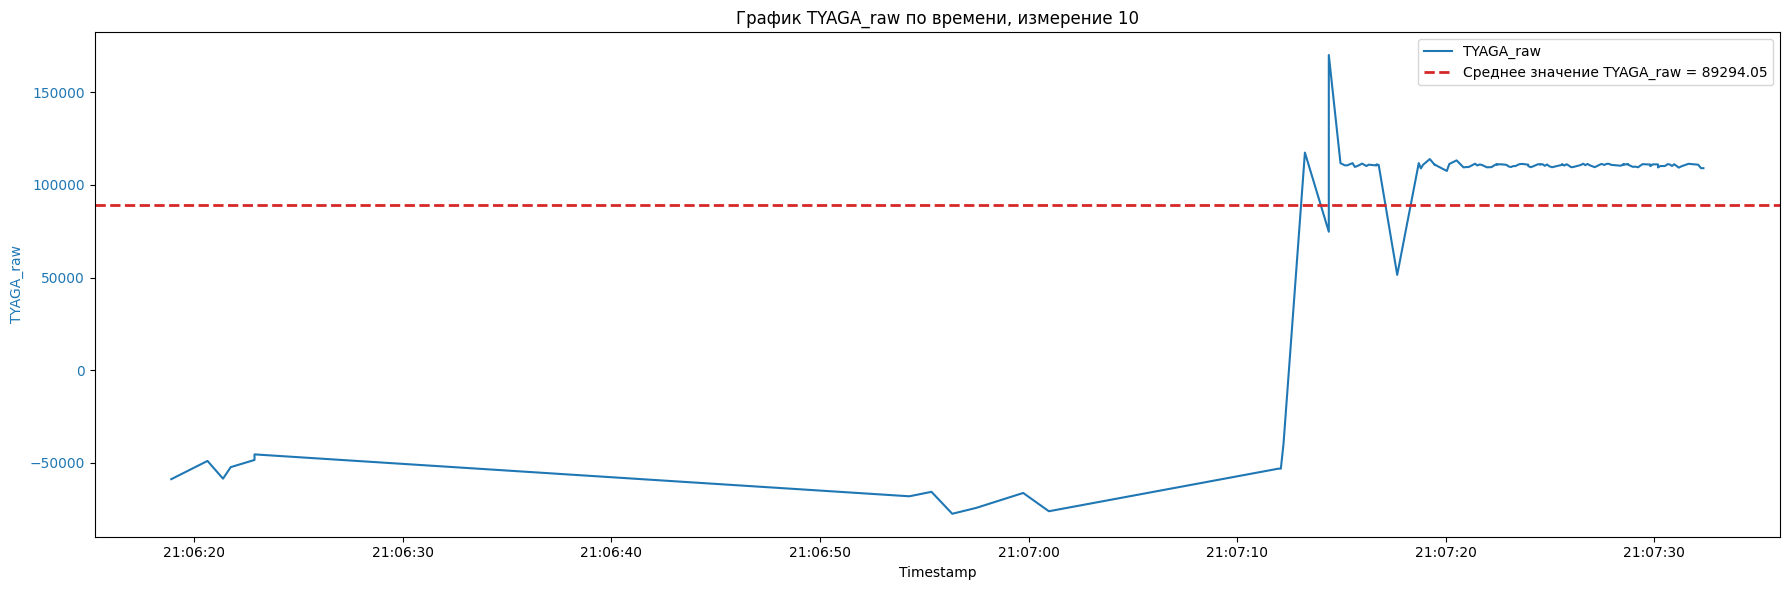

In [41]:
fig_TYAGA(df, 10)

11 взвешивание

In [42]:
df = exp5_all_filtered[(exp5_all_filtered['cumulative_changes']>=20)&(exp5_all_filtered['cumulative_changes']<22)]

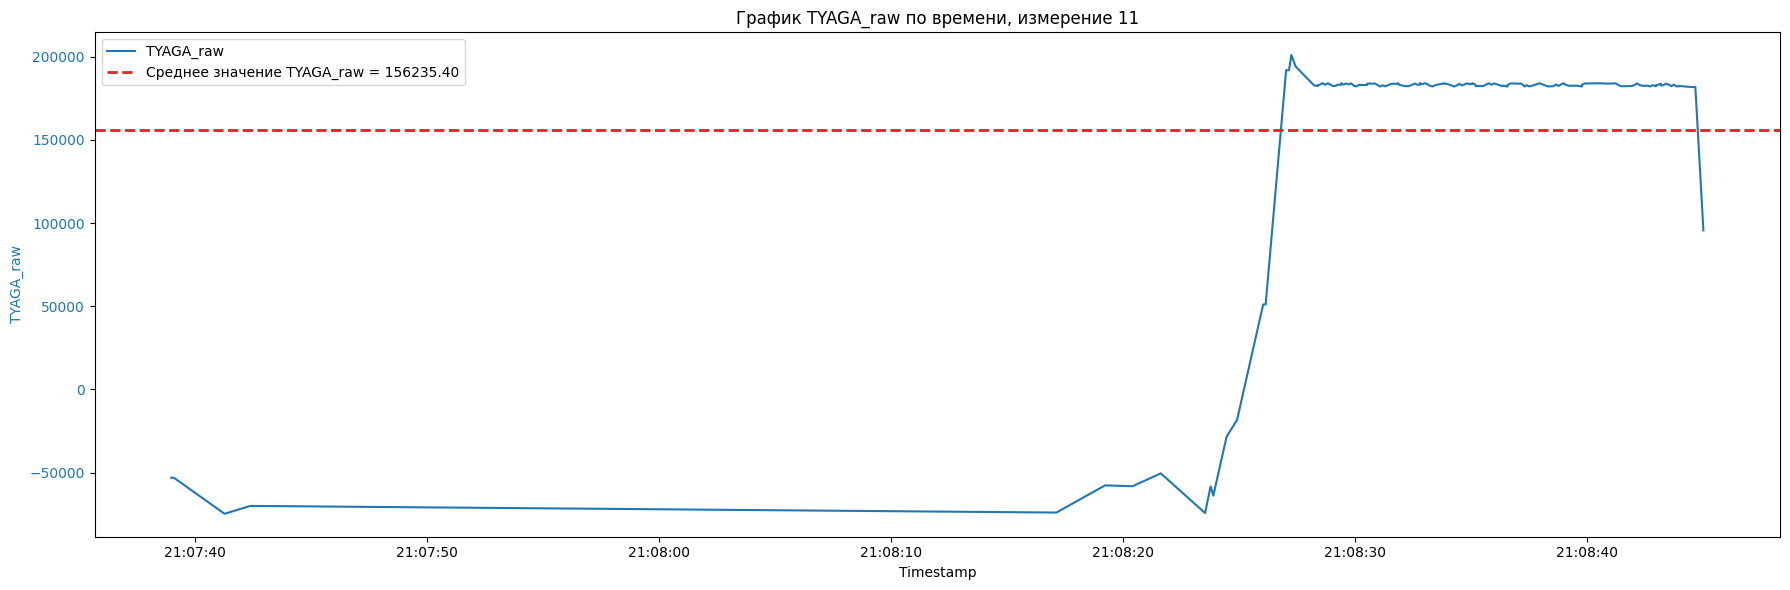

In [43]:
fig_TYAGA(df, 11)

12 взвешивание

In [44]:
df = exp5_all_filtered[(exp5_all_filtered['cumulative_changes']>=22)&(exp5_all_filtered['cumulative_changes']<24)]

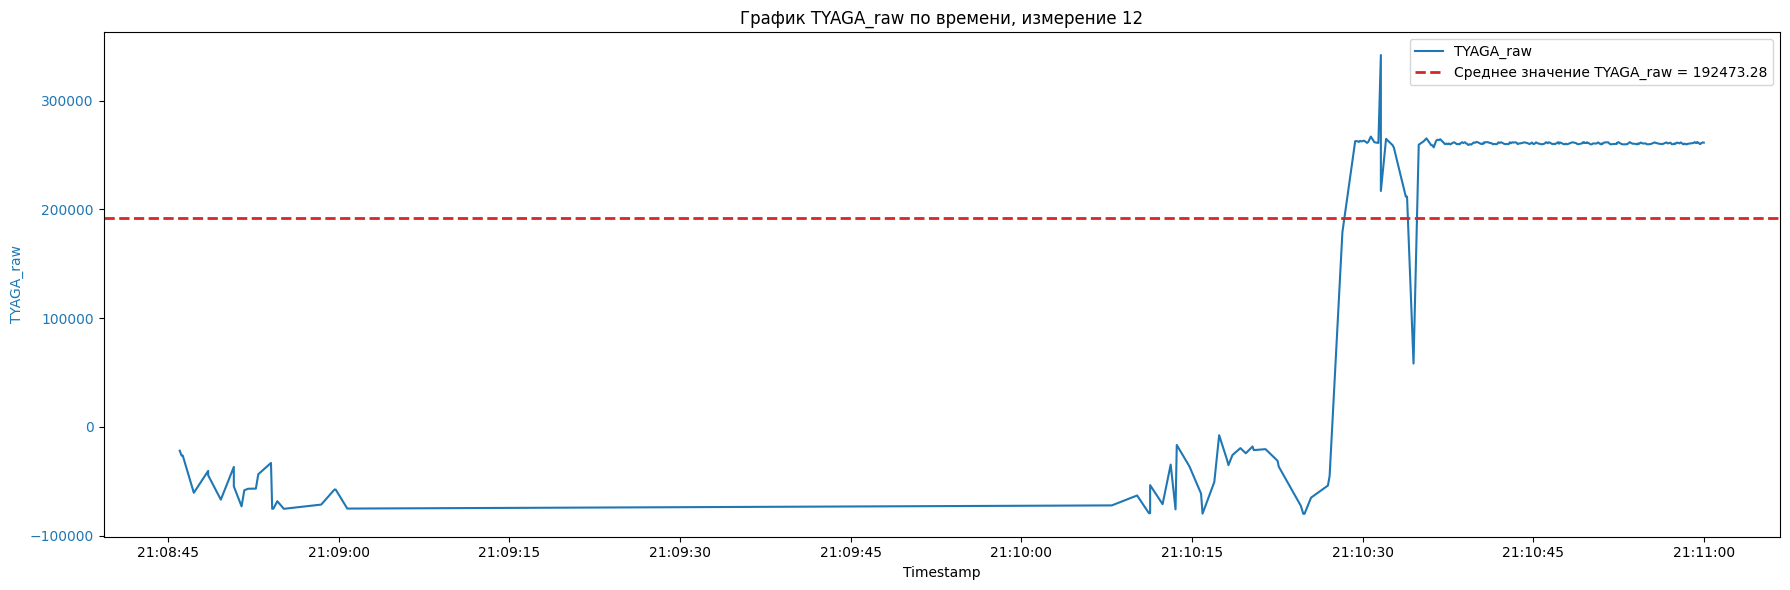

In [45]:
fig_TYAGA(df, 12)

13 взвешивание

In [46]:
df = exp5_all_filtered[(exp5_all_filtered['cumulative_changes']>=24)&(exp5_all_filtered['cumulative_changes']<26)]

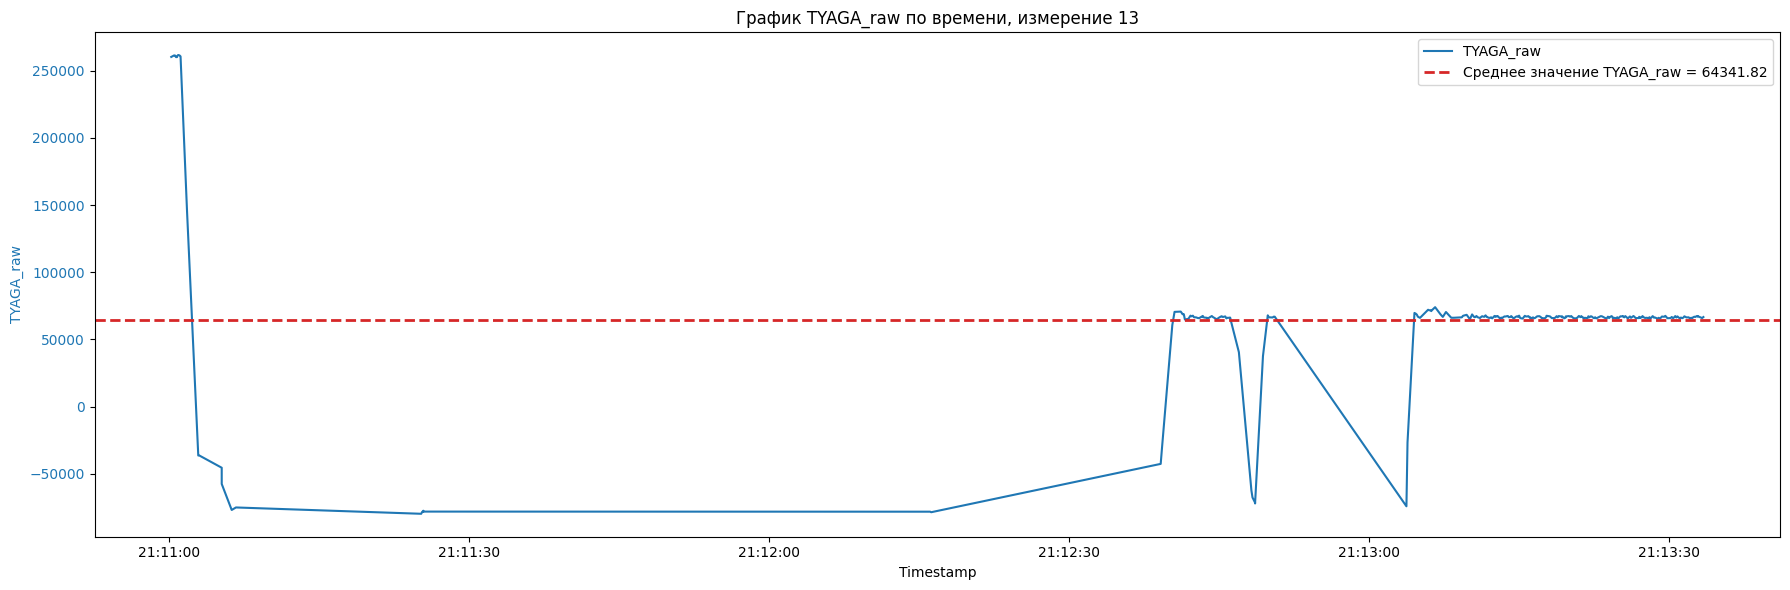

In [47]:
fig_TYAGA(df, 13)

14 взвешивание

In [48]:
df = exp5_all_filtered[(exp5_all_filtered['cumulative_changes']>=26)&(exp5_all_filtered['cumulative_changes']<28)]

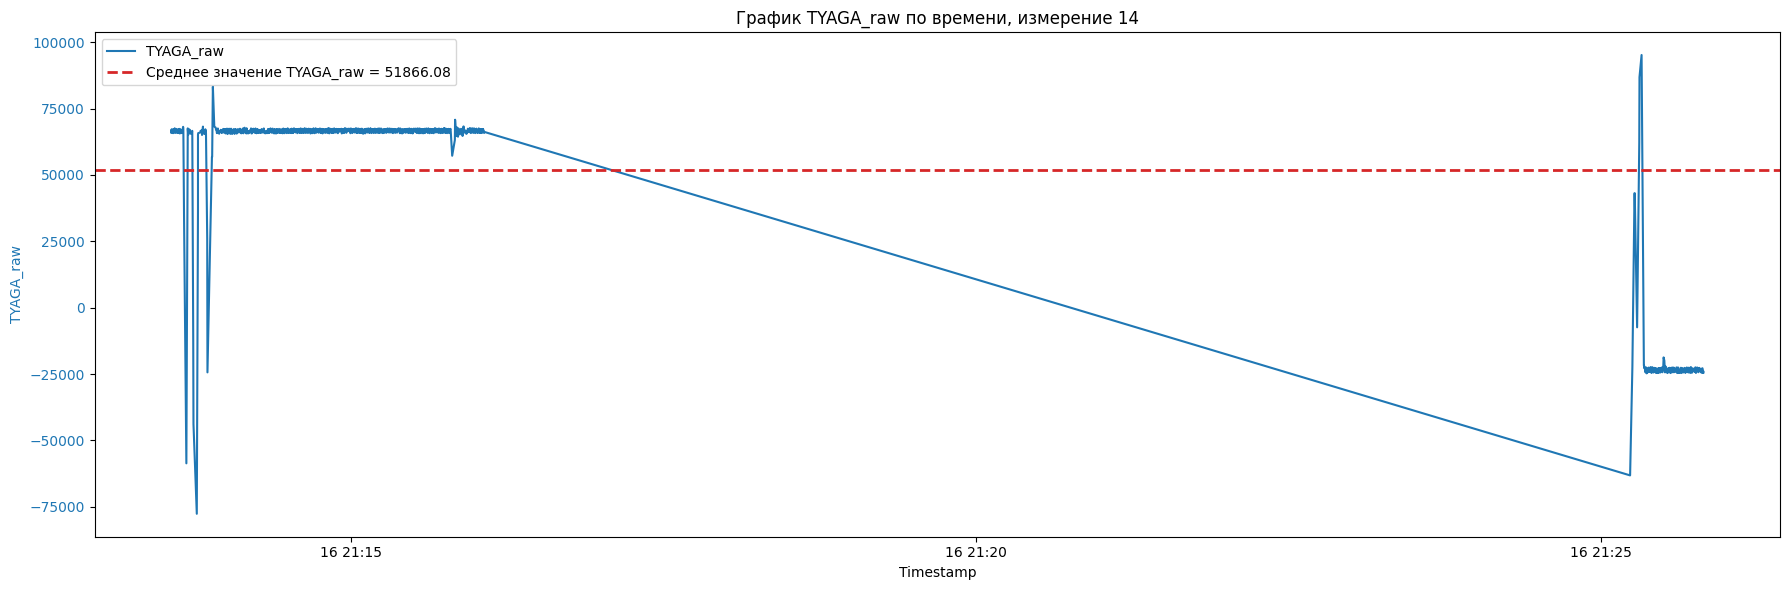

In [49]:
fig_TYAGA(df, 14)

15 взвешивание

In [50]:
df = exp5_all_filtered[(exp5_all_filtered['cumulative_changes']>=28)&(exp5_all_filtered['cumulative_changes']<30)]

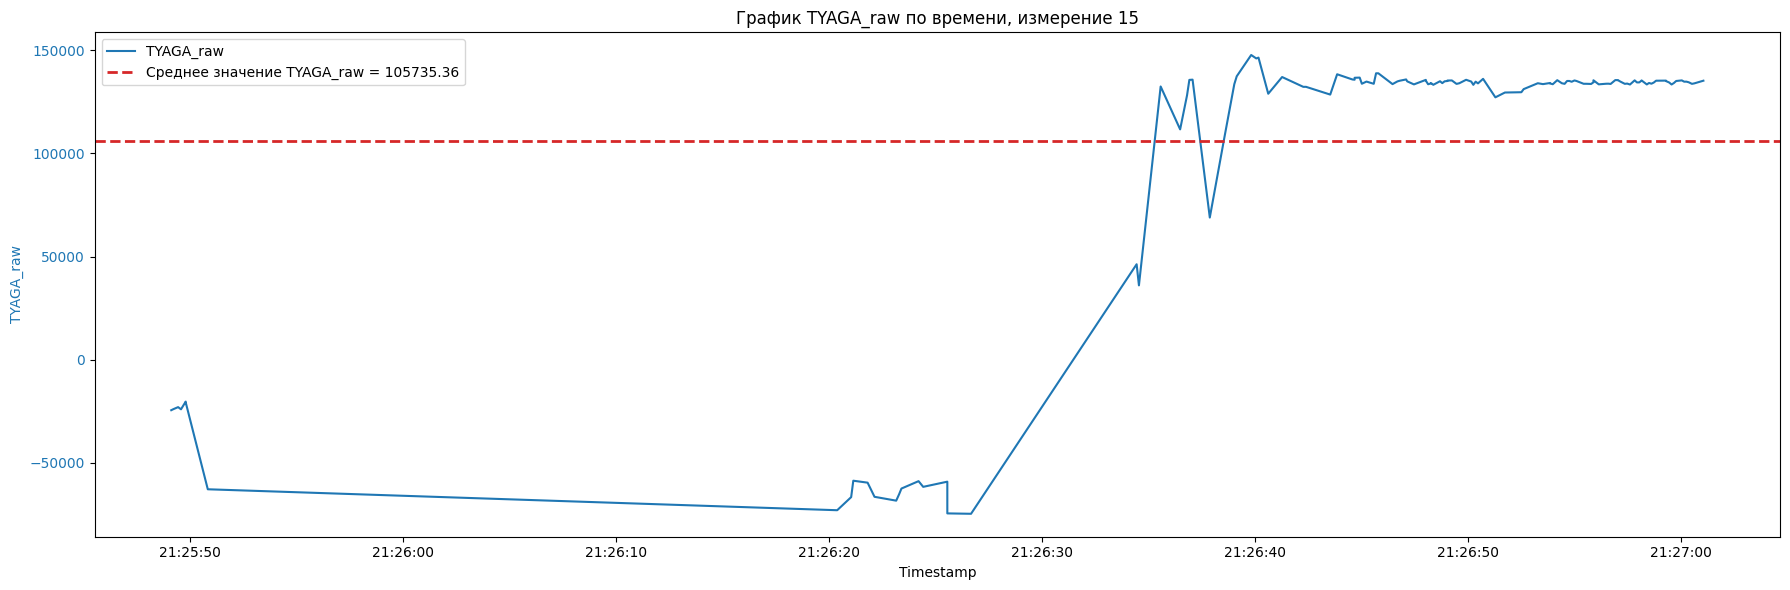

In [51]:
fig_TYAGA(df, 15)

16 взвешивание

In [52]:
df = exp5_all_filtered[(exp5_all_filtered['cumulative_changes']>=30)&(exp5_all_filtered['cumulative_changes']<32)]

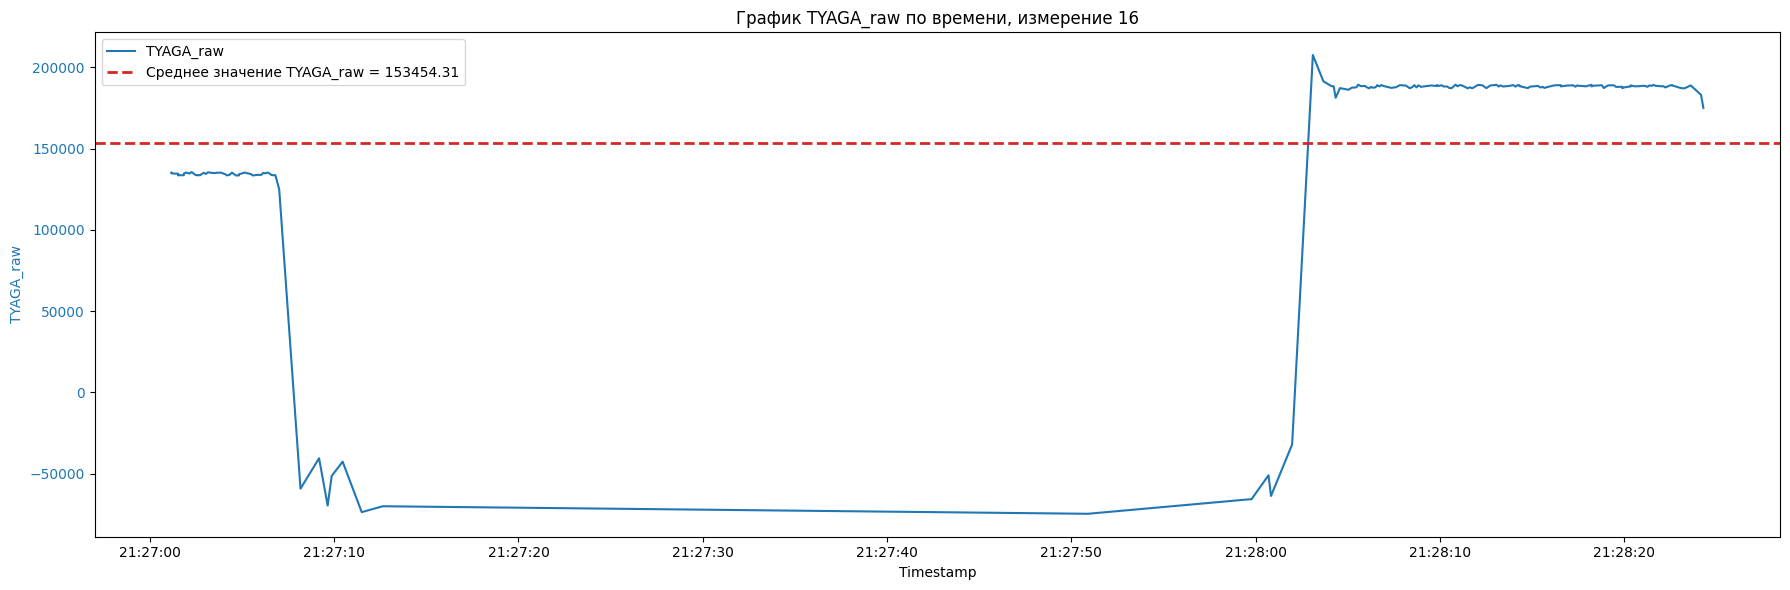

In [53]:
fig_TYAGA(df, 16)

17 взвешивание

In [54]:
df = exp5_all_filtered[(exp5_all_filtered['cumulative_changes']>=32)&(exp5_all_filtered['cumulative_changes']<34)]

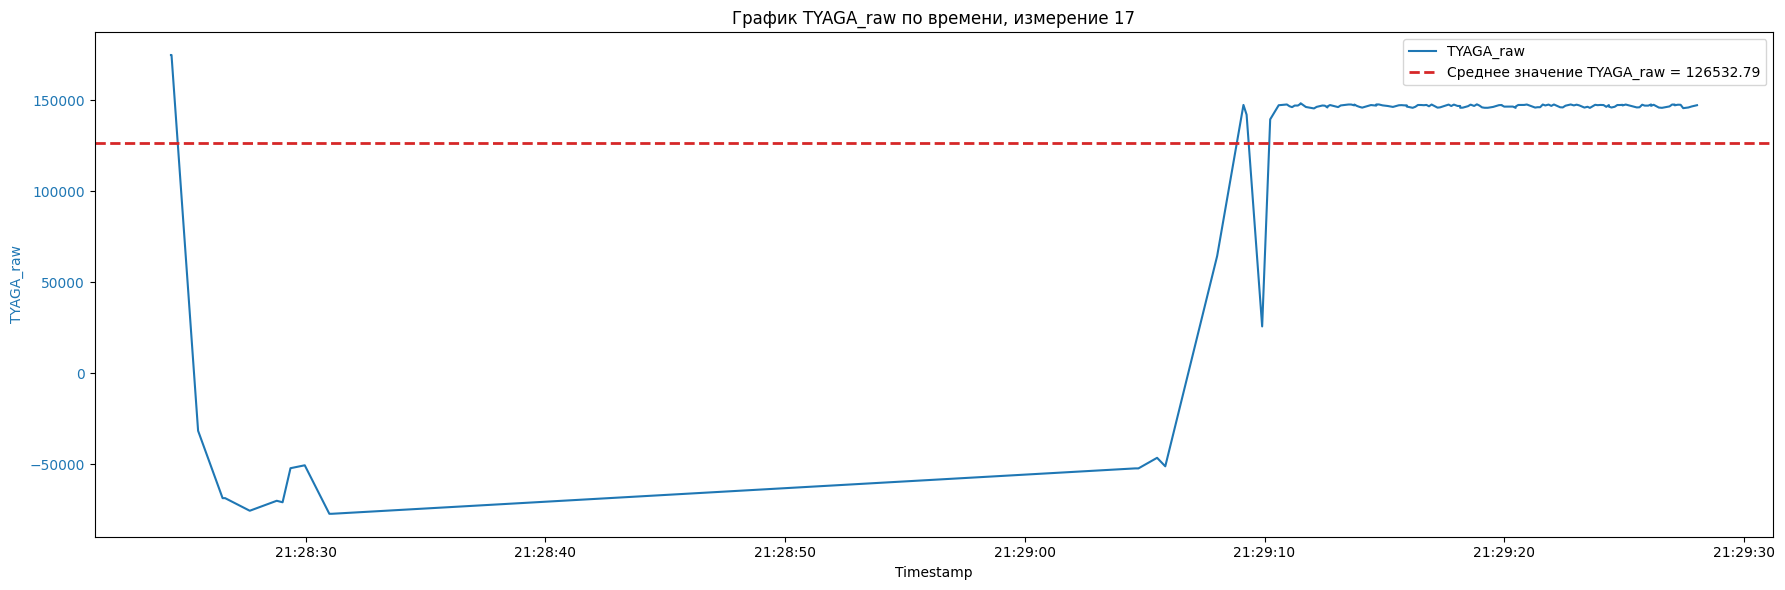

In [55]:
fig_TYAGA(df, 17)

18 взвешивание

In [56]:
df = exp5_all_filtered[(exp5_all_filtered['cumulative_changes']>=34)&(exp5_all_filtered['cumulative_changes']<36)]

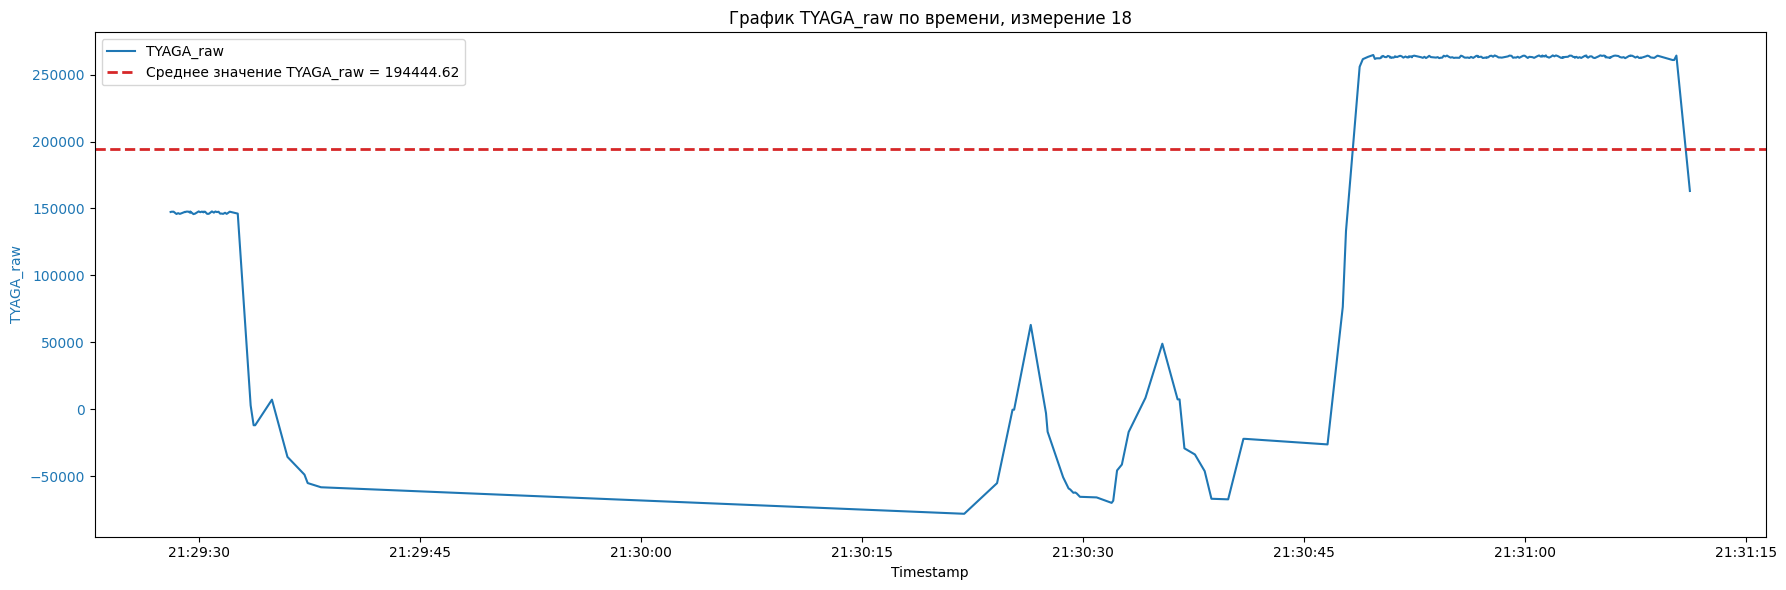

In [57]:
fig_TYAGA(df, 18)

19 взвешивание

In [58]:
df = exp5_all_filtered[(exp5_all_filtered['cumulative_changes']>=36)&(exp5_all_filtered['cumulative_changes']<38)]

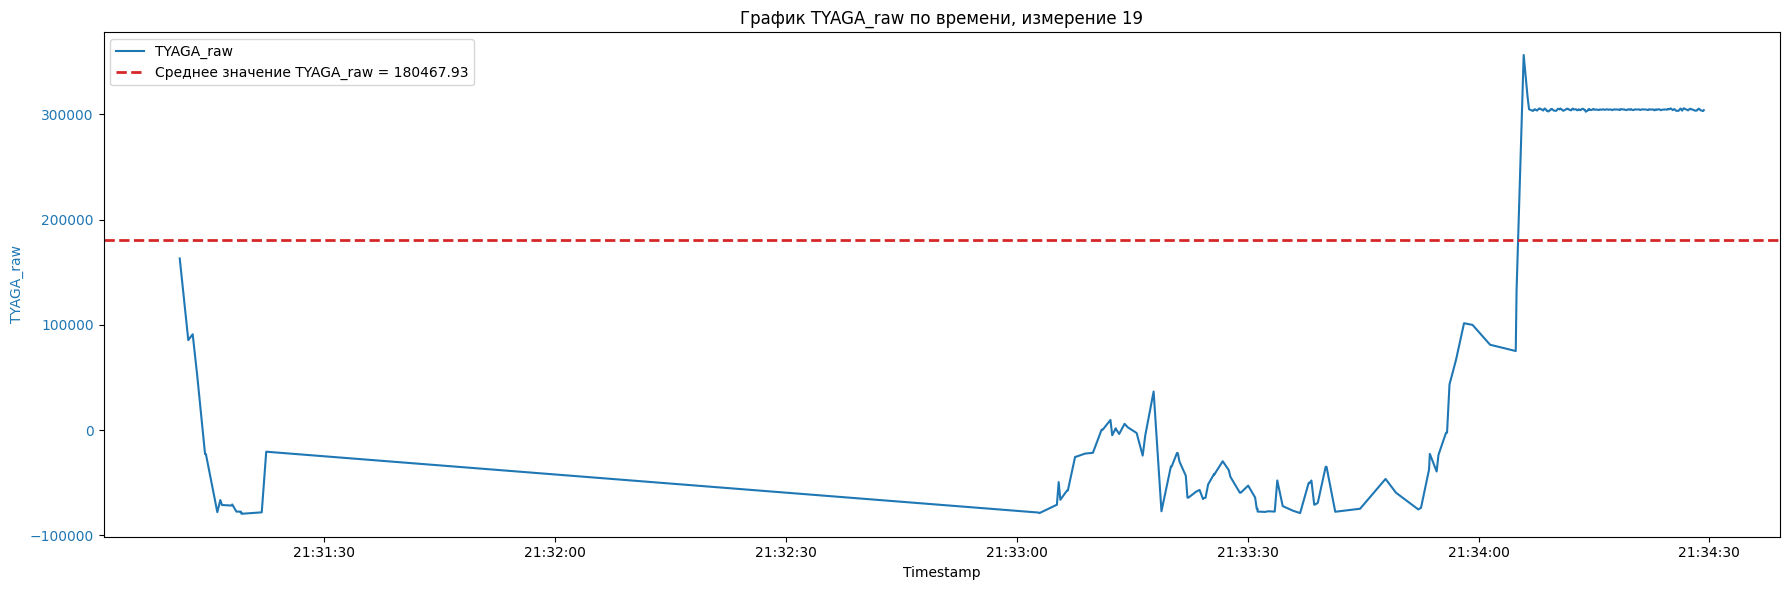

In [59]:
fig_TYAGA(df, 19)

20 взвешивание

In [60]:
df = exp5_all_filtered[(exp5_all_filtered['cumulative_changes']>=38)&(exp5_all_filtered['cumulative_changes']<40)]

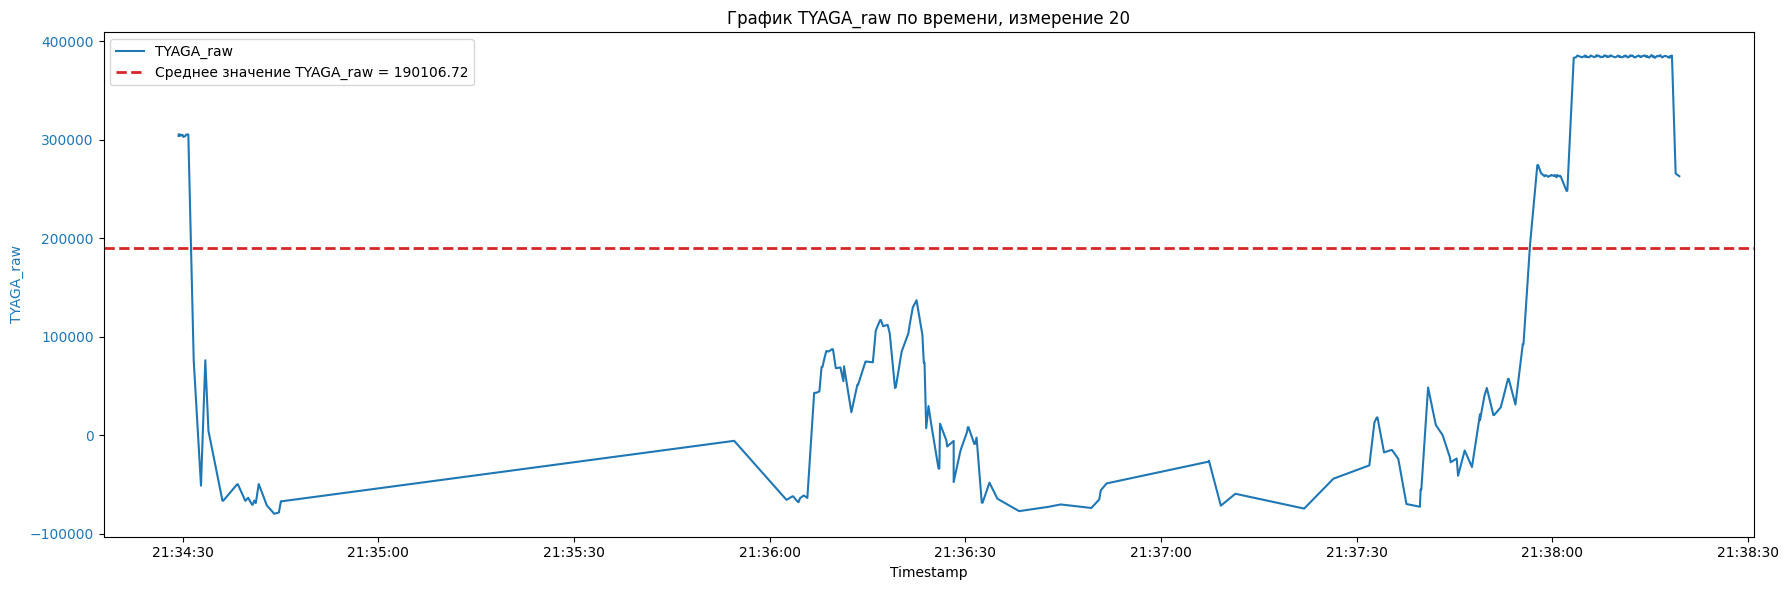

In [61]:
fig_TYAGA(df, 20)

Фильтрация взвешиваний по временным меткам, определенным визуально

In [62]:
# 1 измерение
n = 1
exp5_weight_df.loc[exp5_weight_df['measurement'] == n, 'start_time'] = '2025-01-16 20:52:30'
exp5_weight_df.loc[exp5_weight_df['measurement'] == n, 'end_time'] = '2025-01-16 20:52:38'

In [63]:
# 2 измерение
n = 2
exp5_weight_df.loc[exp5_weight_df['measurement'] == n, 'start_time'] = '2025-01-16 20:53:20'
exp5_weight_df.loc[exp5_weight_df['measurement'] == n, 'end_time'] = '2025-01-16 20:53:30'

In [64]:
# 3 измерение
n = 3
exp5_weight_df.loc[exp5_weight_df['measurement'] == n, 'start_time'] = '2025-01-16 20:54:05'
exp5_weight_df.loc[exp5_weight_df['measurement'] == n, 'end_time'] = '2025-01-16 20:54:17'

In [65]:
# 4 измерение
n = 4
exp5_weight_df.loc[exp5_weight_df['measurement'] == n, 'start_time'] = '2025-01-16 20:55:05'
exp5_weight_df.loc[exp5_weight_df['measurement'] == n, 'end_time'] = '2025-01-16 20:55:14'

In [66]:
# 5 измерение
n = 5
exp5_weight_df.loc[exp5_weight_df['measurement'] == n, 'start_time'] = '2025-01-16 20:56:41'
exp5_weight_df.loc[exp5_weight_df['measurement'] == n, 'end_time'] = '2025-01-16 20:56:51'

In [67]:
# 6 измерение
n = 6
exp5_weight_df.loc[exp5_weight_df['measurement'] == n, 'start_time'] = '2025-01-16 20:58:50'
exp5_weight_df.loc[exp5_weight_df['measurement'] == n, 'end_time'] = '2025-01-16 20:59:15'

In [68]:
# 7 измерение
n = 7
exp5_weight_df.loc[exp5_weight_df['measurement'] == n, 'start_time'] = '2025-01-16 21:01:50'
exp5_weight_df.loc[exp5_weight_df['measurement'] == n, 'end_time'] = '2025-01-16 21:02:00'

In [69]:
# 8 измерение
n = 8
exp5_weight_df.loc[exp5_weight_df['measurement'] == n, 'start_time'] = '2025-01-16 21:04:20'
exp5_weight_df.loc[exp5_weight_df['measurement'] == n, 'end_time'] = '2025-01-16 21:04:45'

In [70]:
# 9 измерение
n = 9
exp5_weight_df.loc[exp5_weight_df['measurement'] == n, 'start_time'] = '2025-01-16 21:06:00'
exp5_weight_df.loc[exp5_weight_df['measurement'] == n, 'end_time'] = '2025-01-16 21:06:10'

In [71]:
# 10 измерение
n = 10
exp5_weight_df.loc[exp5_weight_df['measurement'] == n, 'start_time'] = '2025-01-16 21:07:22'
exp5_weight_df.loc[exp5_weight_df['measurement'] == n, 'end_time'] = '2025-01-16 21:07:32'

In [72]:
# 11 измерение
n = 11
exp5_weight_df.loc[exp5_weight_df['measurement'] == n, 'start_time'] = '2025-01-16 21:08:30'
exp5_weight_df.loc[exp5_weight_df['measurement'] == n, 'end_time'] = '2025-01-16 21:08:40'

In [73]:
# 12 измерение
n = 12
exp5_weight_df.loc[exp5_weight_df['measurement'] == n, 'start_time'] = '2025-01-16 21:10:40'
exp5_weight_df.loc[exp5_weight_df['measurement'] == n, 'end_time'] = '2025-01-16 21:11:00'

In [74]:
# 13 измерение
n = 13
exp5_weight_df.loc[exp5_weight_df['measurement'] == n, 'start_time'] = '2025-01-16 21:13:10'
exp5_weight_df.loc[exp5_weight_df['measurement'] == n, 'end_time'] = '2025-01-16 21:13:30'

In [75]:
# 14 измерение
n = 14
exp5_weight_df.loc[exp5_weight_df['measurement'] == n, 'start_time'] = '2025-01-16 21:15:10'
exp5_weight_df.loc[exp5_weight_df['measurement'] == n, 'end_time'] = '2025-01-16 21:15:30'

In [76]:
# 15 измерение
n = 15
exp5_weight_df.loc[exp5_weight_df['measurement'] == n, 'start_time'] = '2025-01-16 21:26:54'
exp5_weight_df.loc[exp5_weight_df['measurement'] == n, 'end_time'] = '2025-01-16 21:27:00'

In [77]:
# 16 измерение
n = 16
exp5_weight_df.loc[exp5_weight_df['measurement'] == n, 'start_time'] = '2025-01-16 21:28:10'
exp5_weight_df.loc[exp5_weight_df['measurement'] == n, 'end_time'] = '2025-01-16 21:28:20'

In [78]:
# 17 измерение
n = 17
exp5_weight_df.loc[exp5_weight_df['measurement'] == n, 'start_time'] = '2025-01-16 21:29:15'
exp5_weight_df.loc[exp5_weight_df['measurement'] == n, 'end_time'] = '2025-01-16 21:29:25'

In [79]:
# 18 измерение
n = 18
exp5_weight_df.loc[exp5_weight_df['measurement'] == n, 'start_time'] = '2025-01-16 21:30:55'
exp5_weight_df.loc[exp5_weight_df['measurement'] == n, 'end_time'] = '2025-01-16 21:31:05'

In [80]:
# 19 измерение
n = 19
exp5_weight_df.loc[exp5_weight_df['measurement'] == n, 'start_time'] = '2025-01-16 21:34:15'
exp5_weight_df.loc[exp5_weight_df['measurement'] == n, 'end_time'] = '2025-01-16 21:34:24'

In [81]:
# 20 измерение
n = 20
exp5_weight_df.loc[exp5_weight_df['measurement'] == n, 'start_time'] = '2025-01-16 21:38:05'
exp5_weight_df.loc[exp5_weight_df['measurement'] == n, 'end_time'] = '2025-01-16 21:38:15'

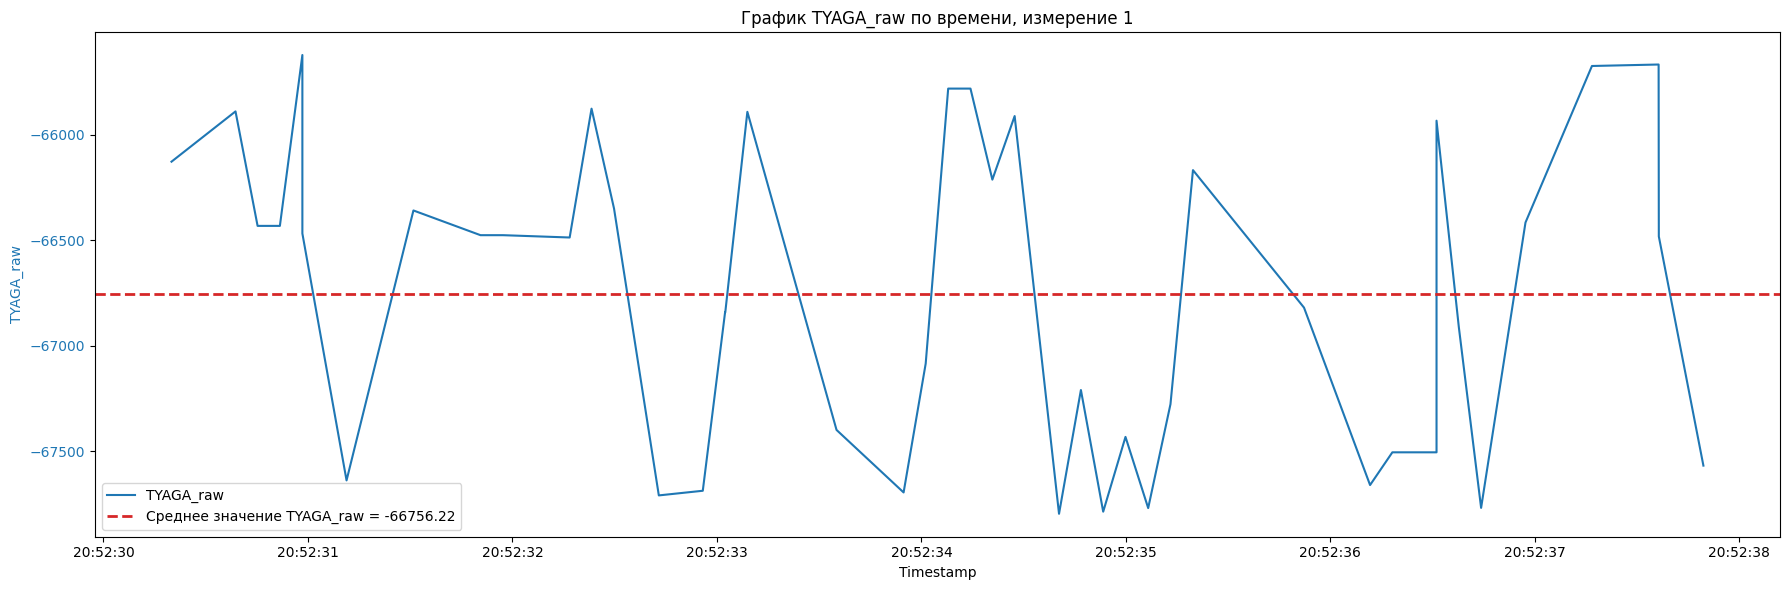

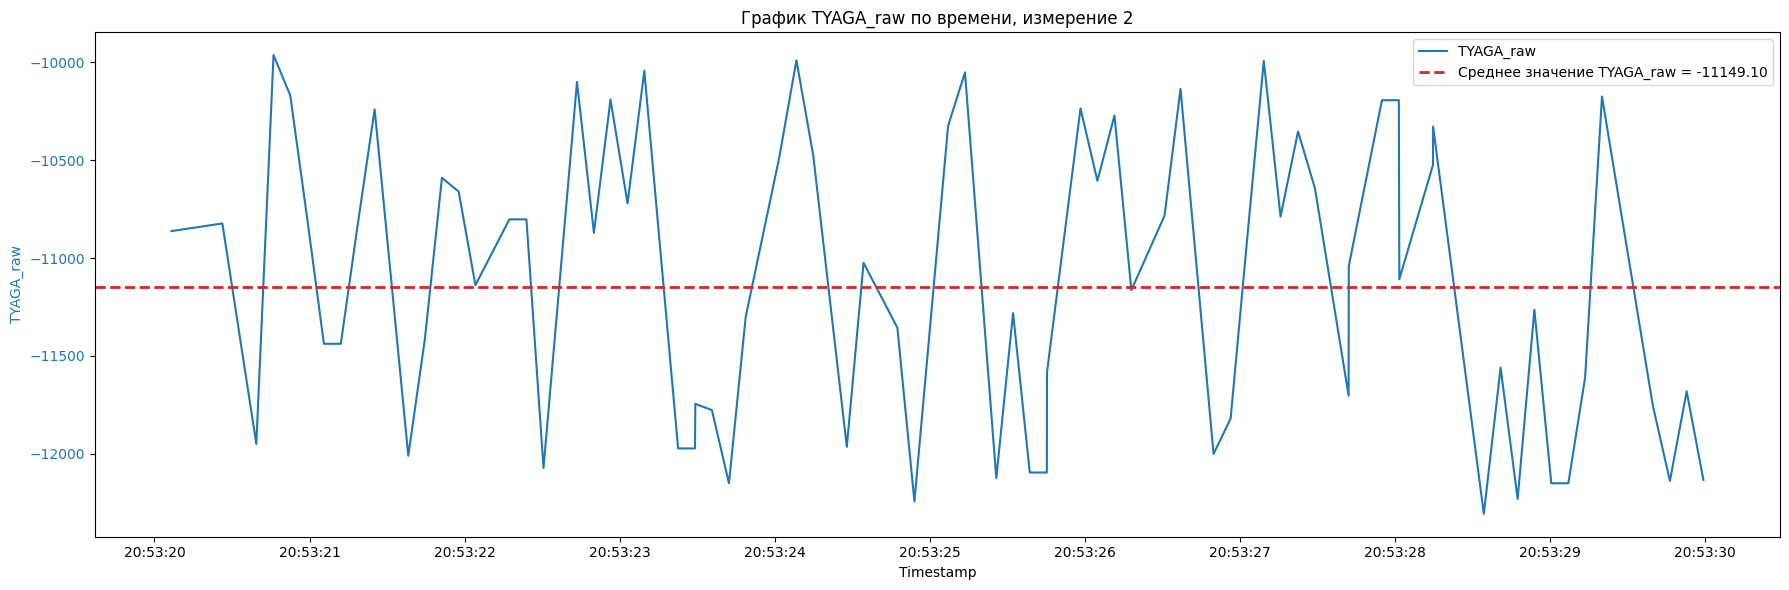

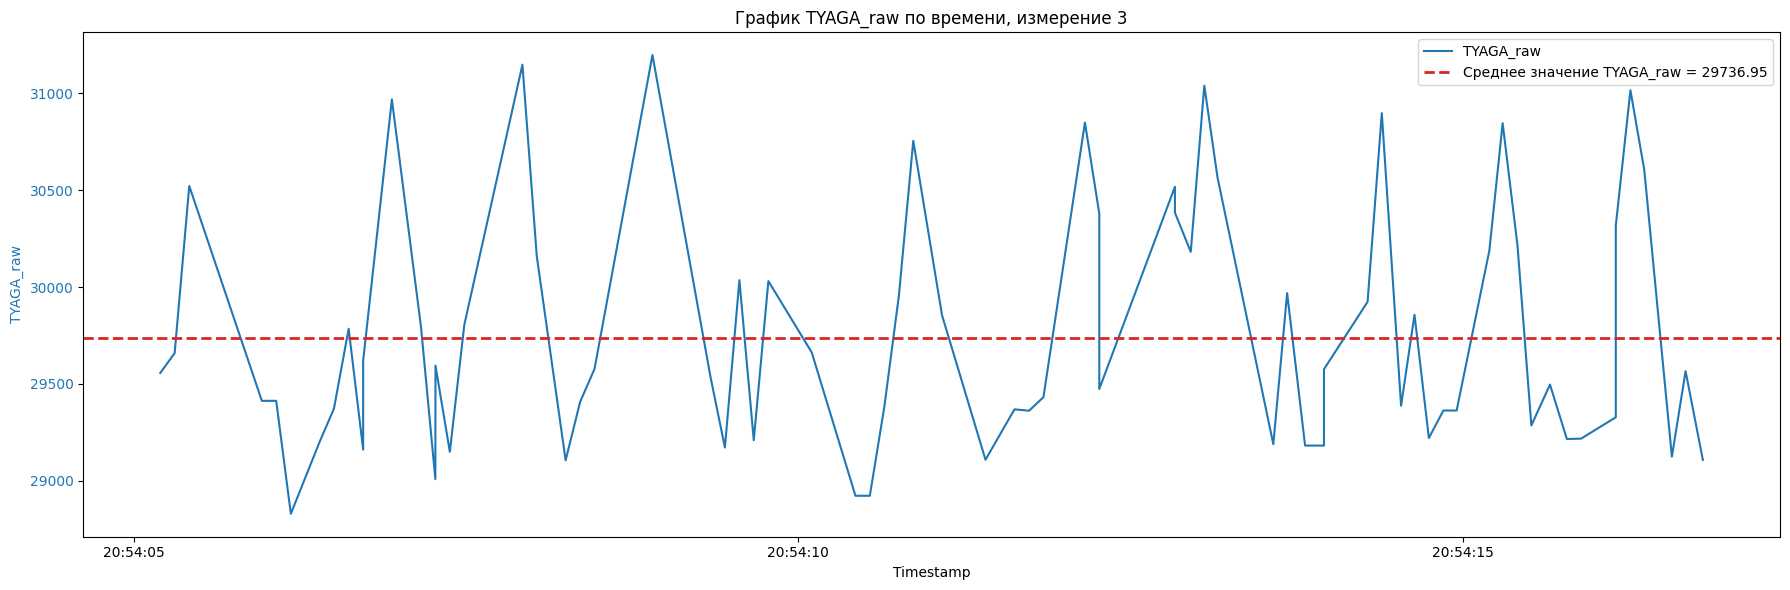

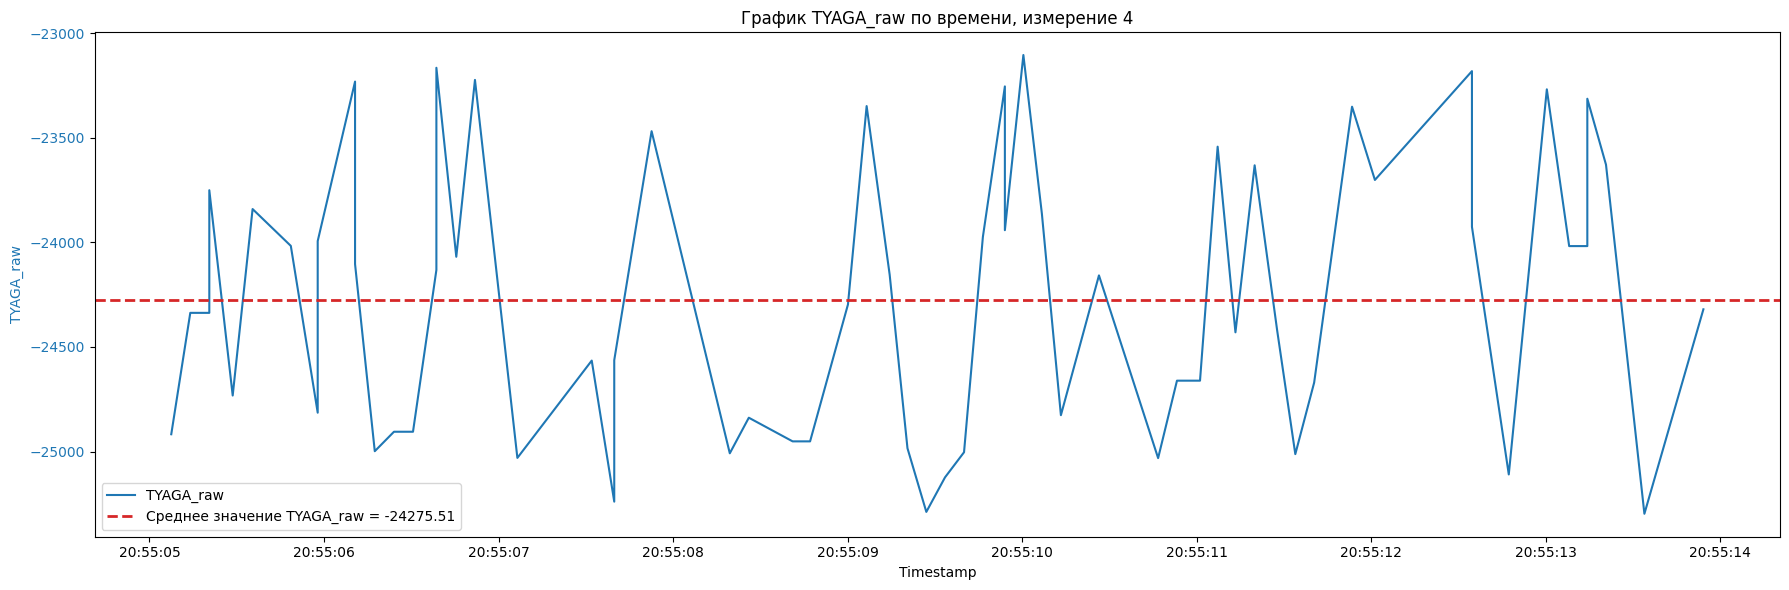

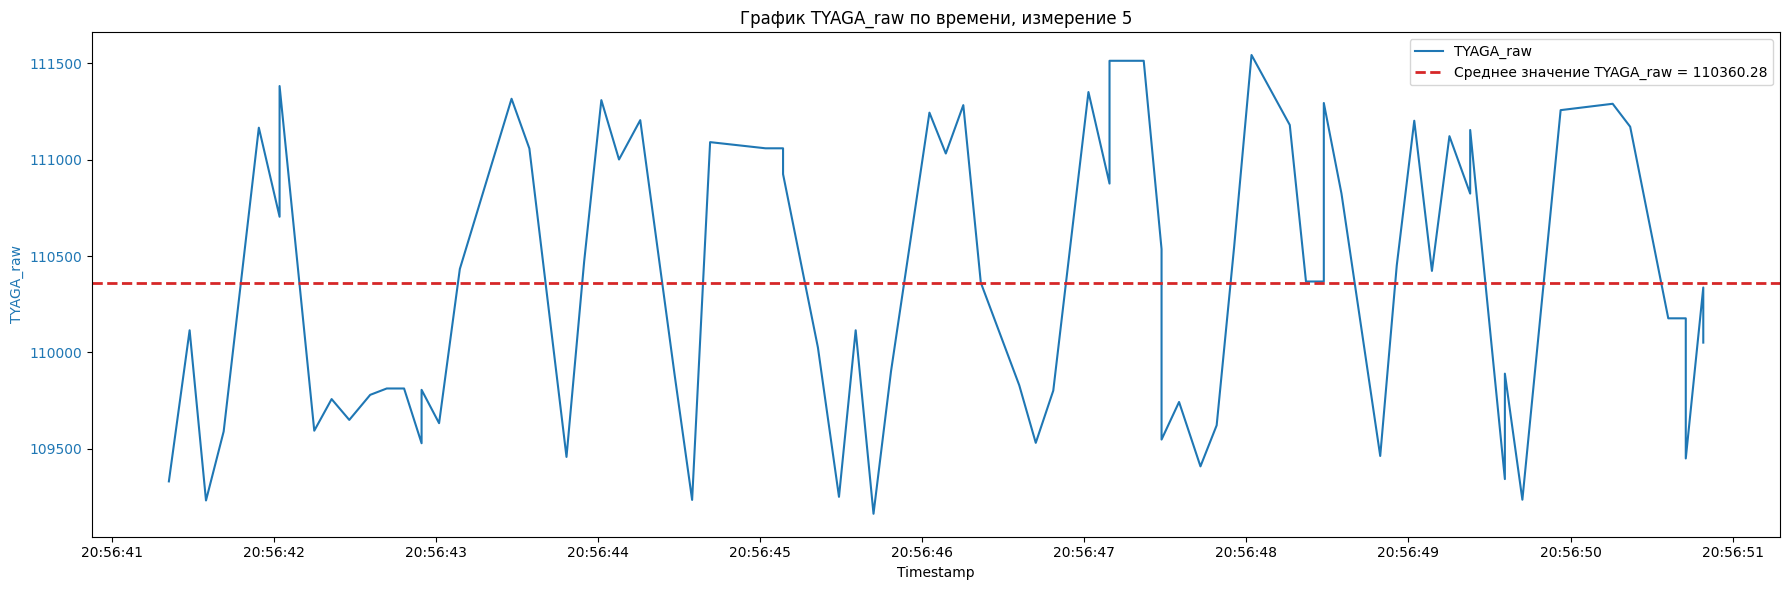

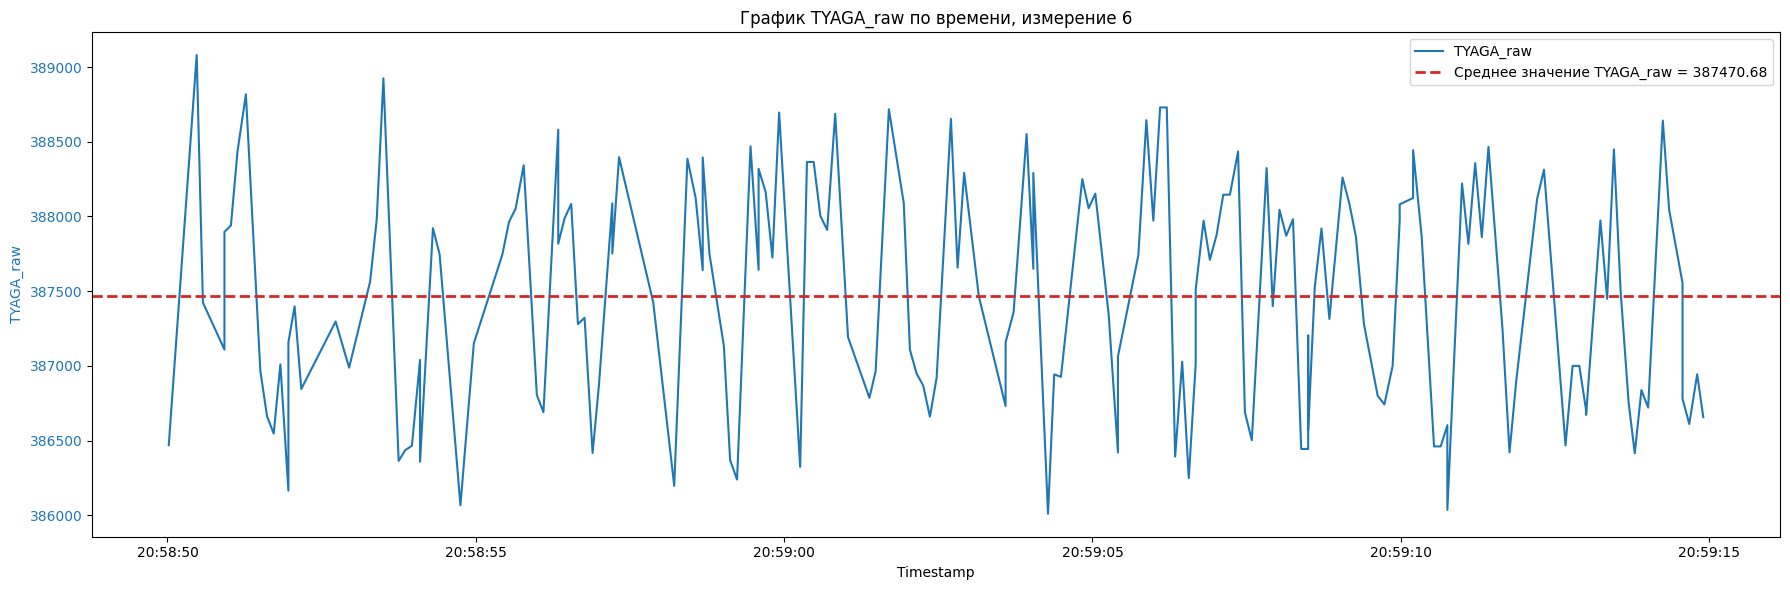

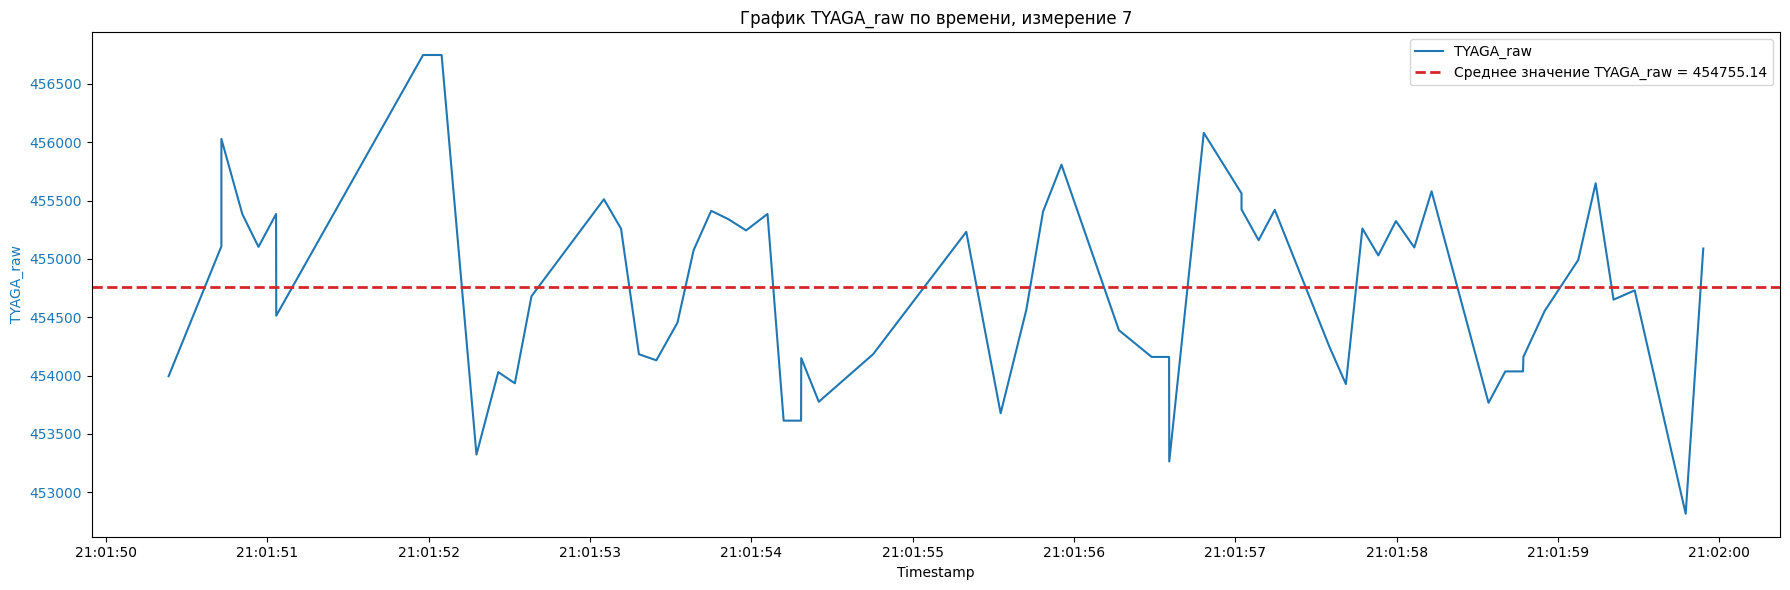

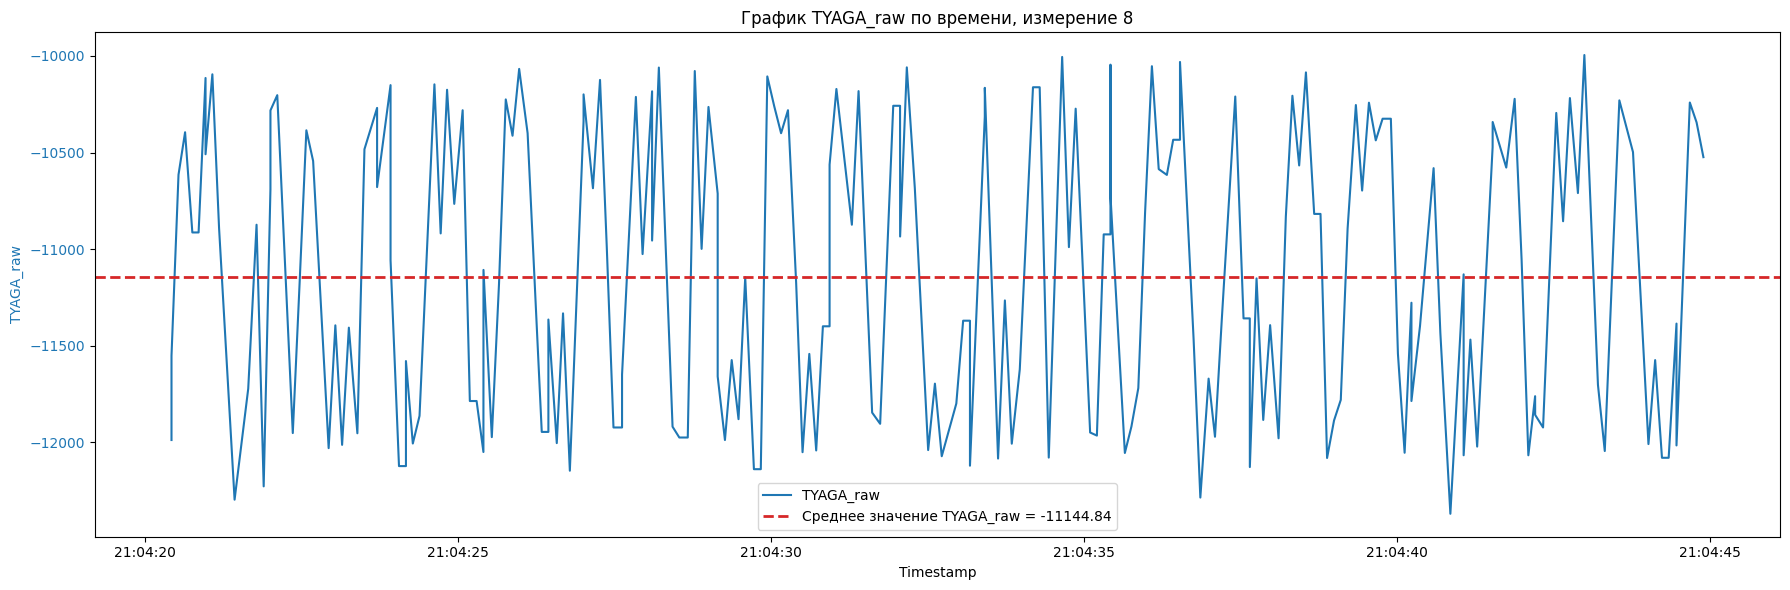

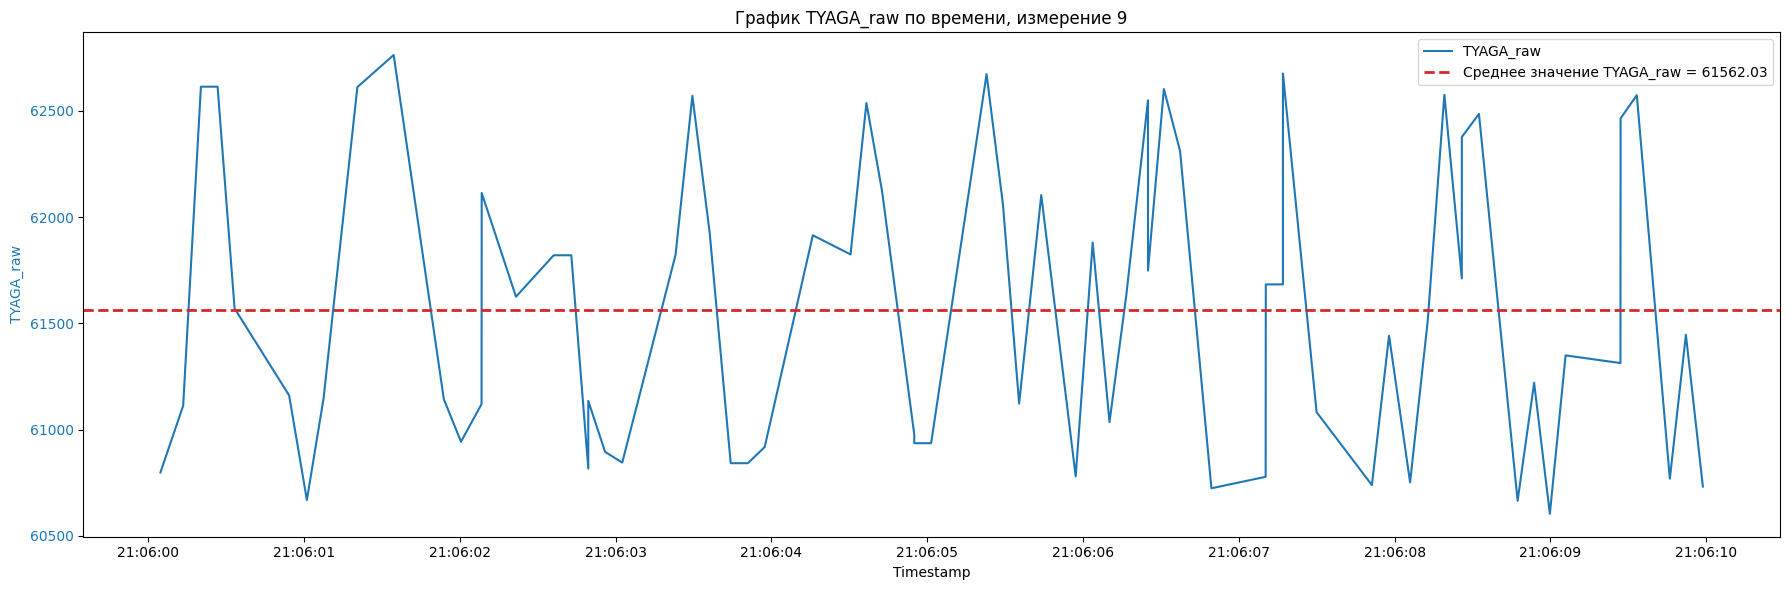

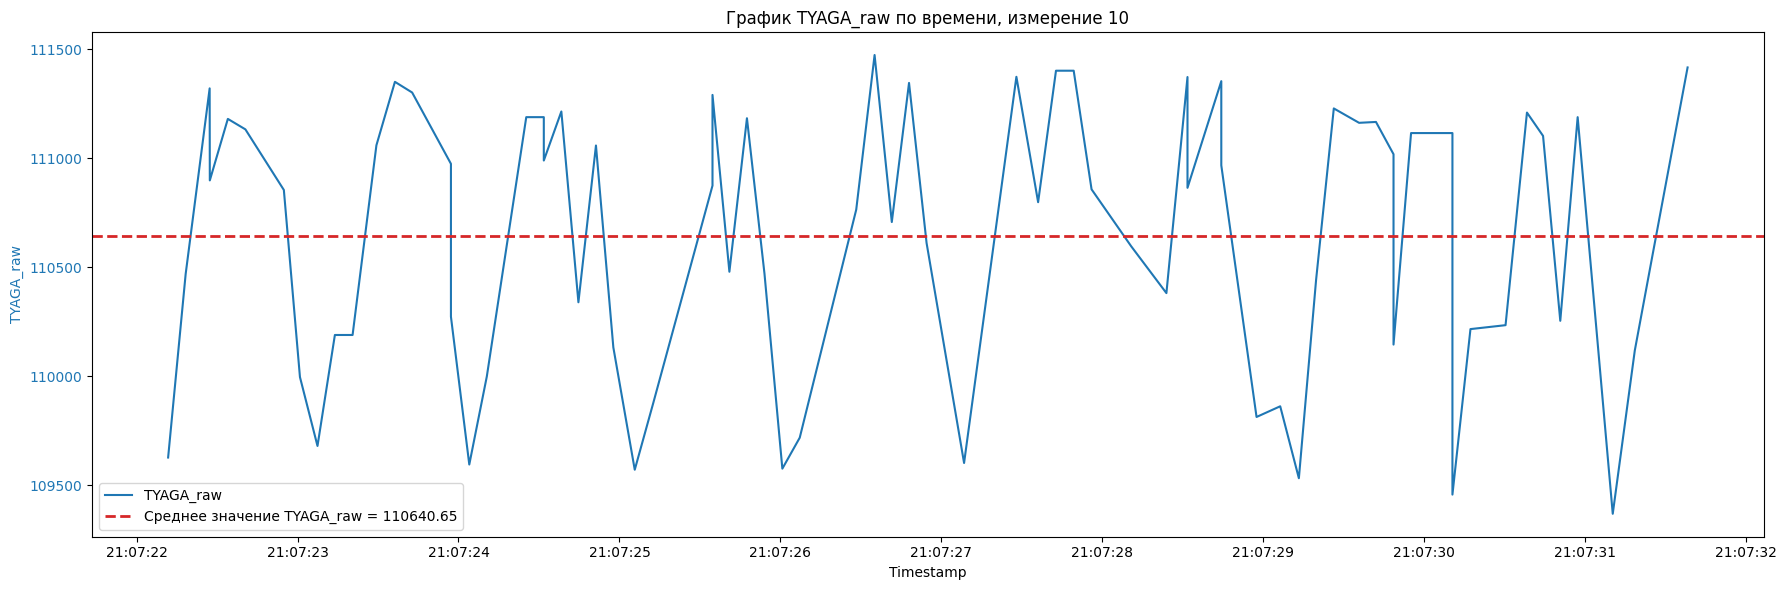

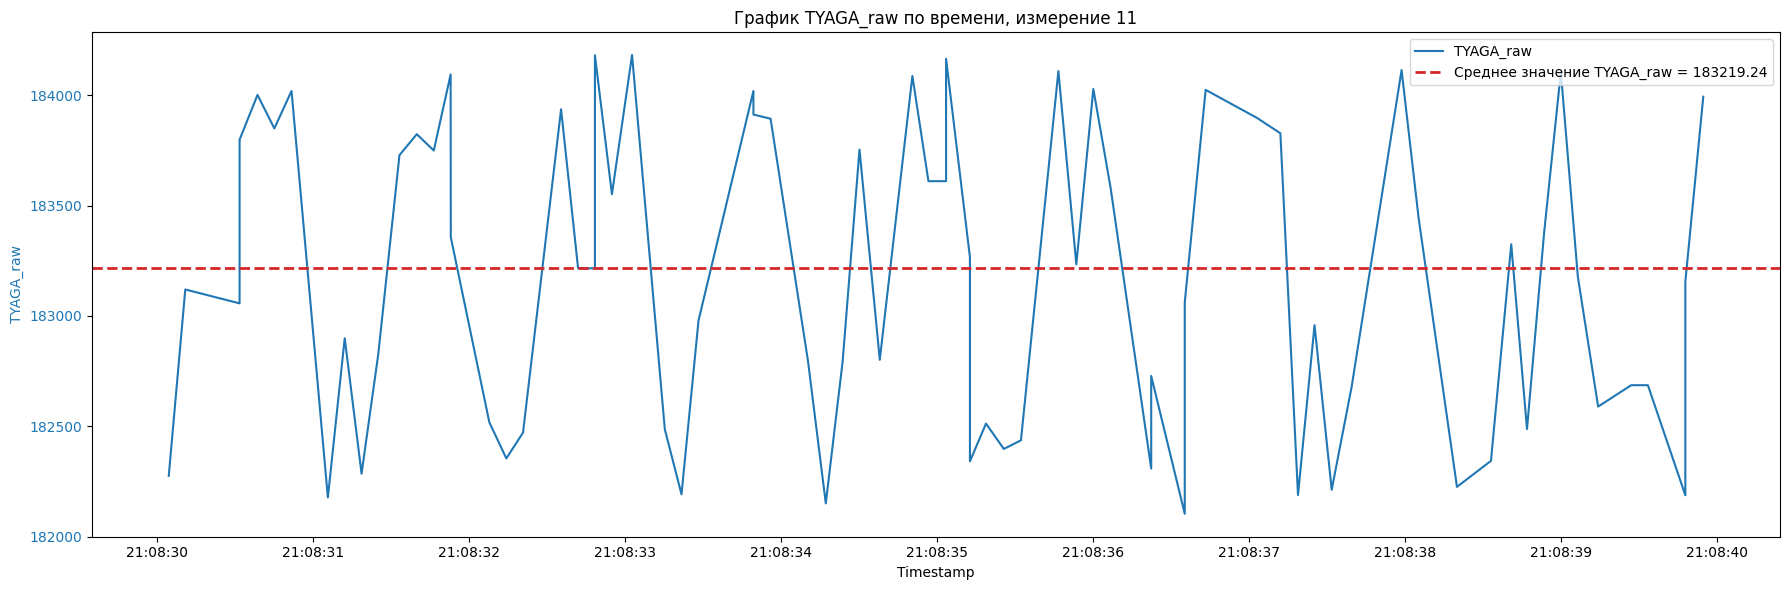

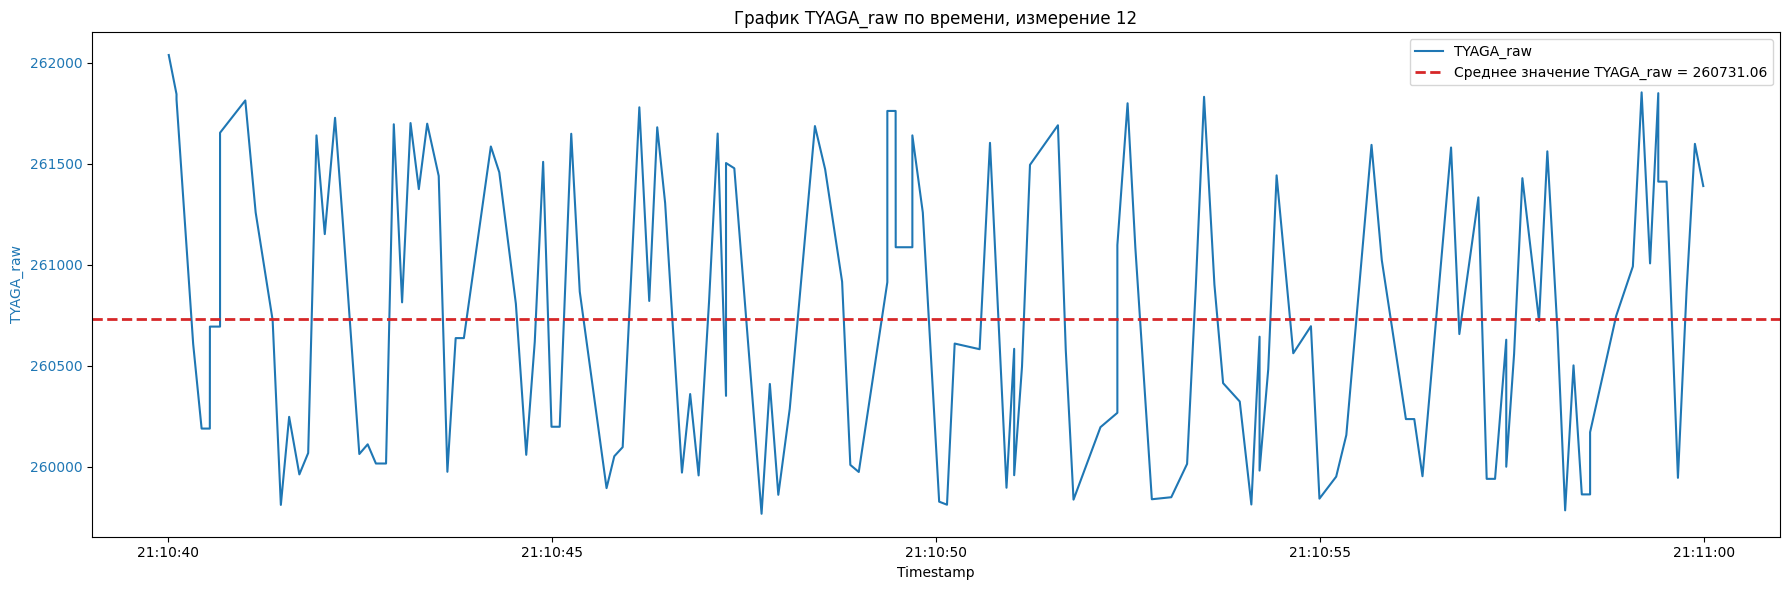

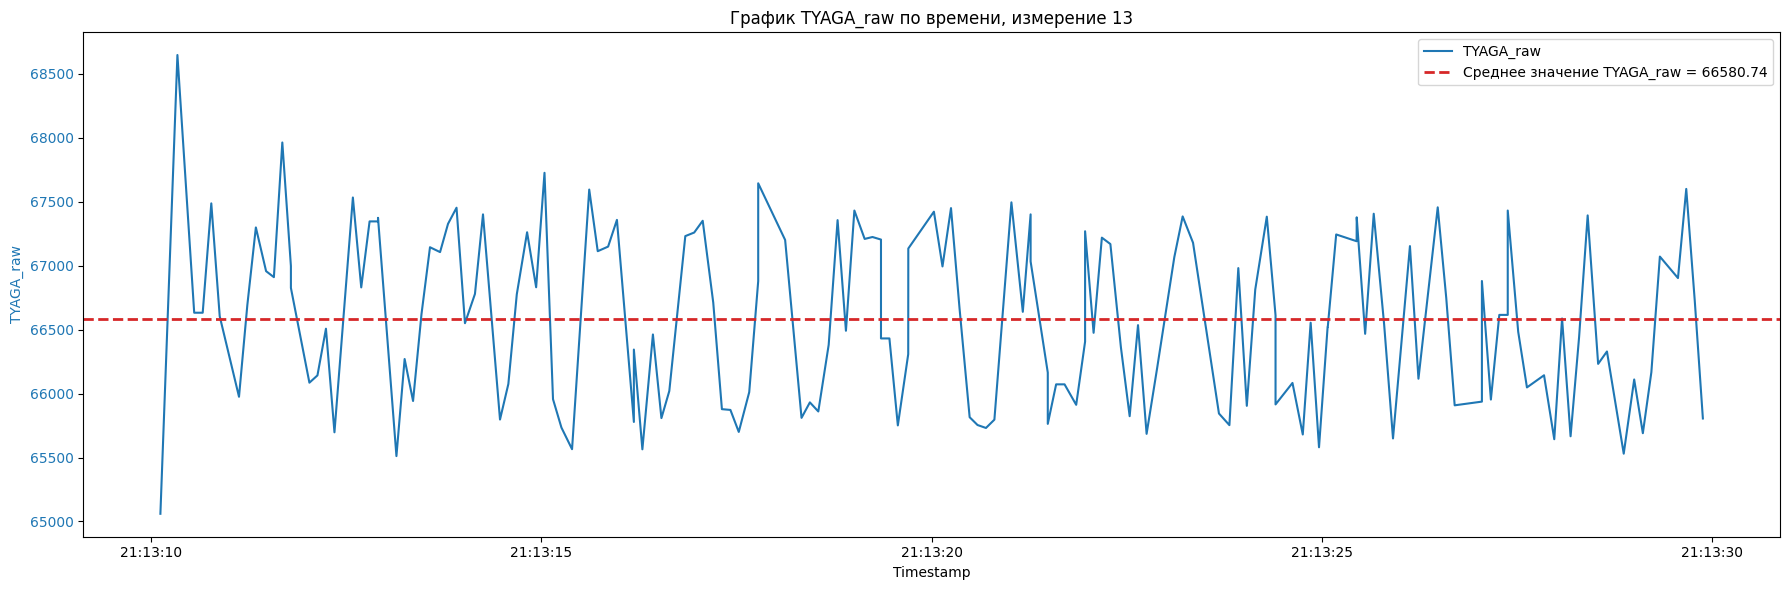

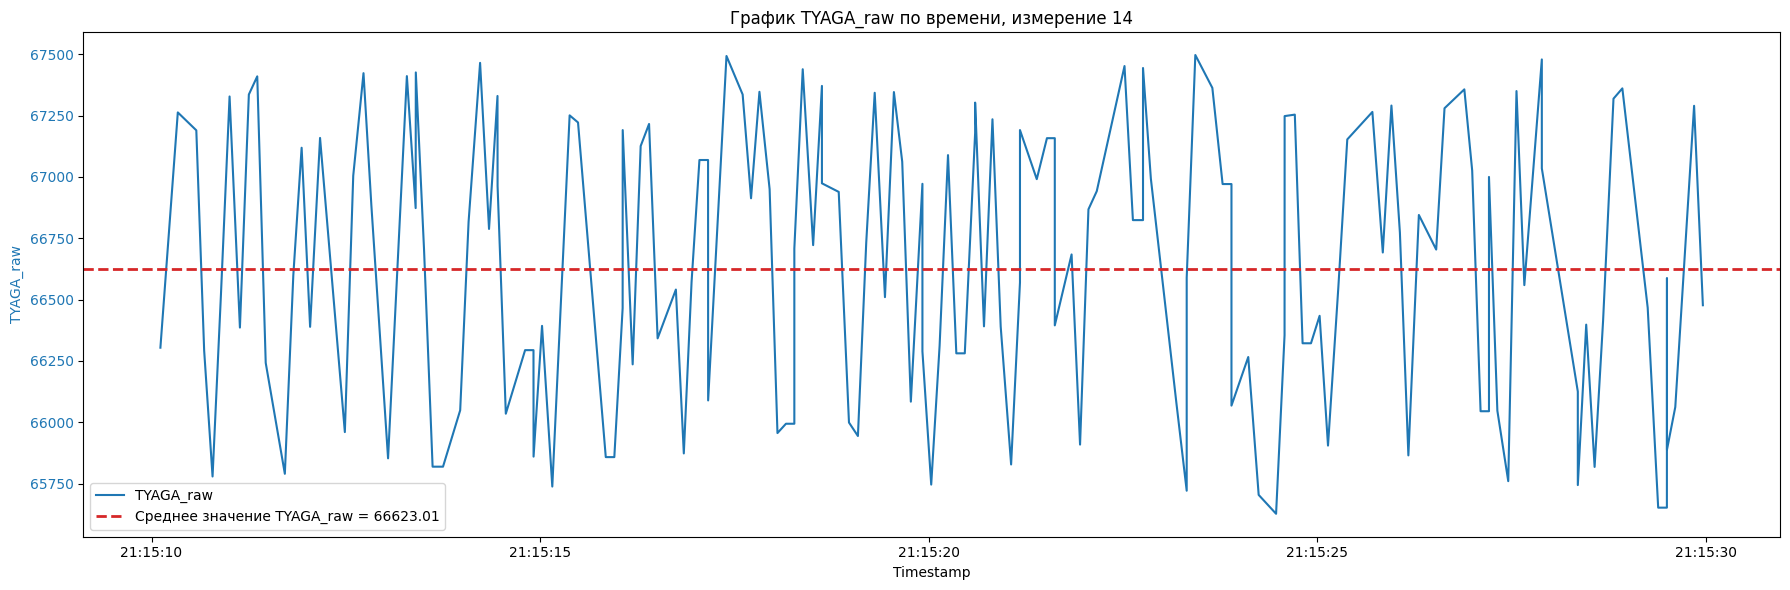

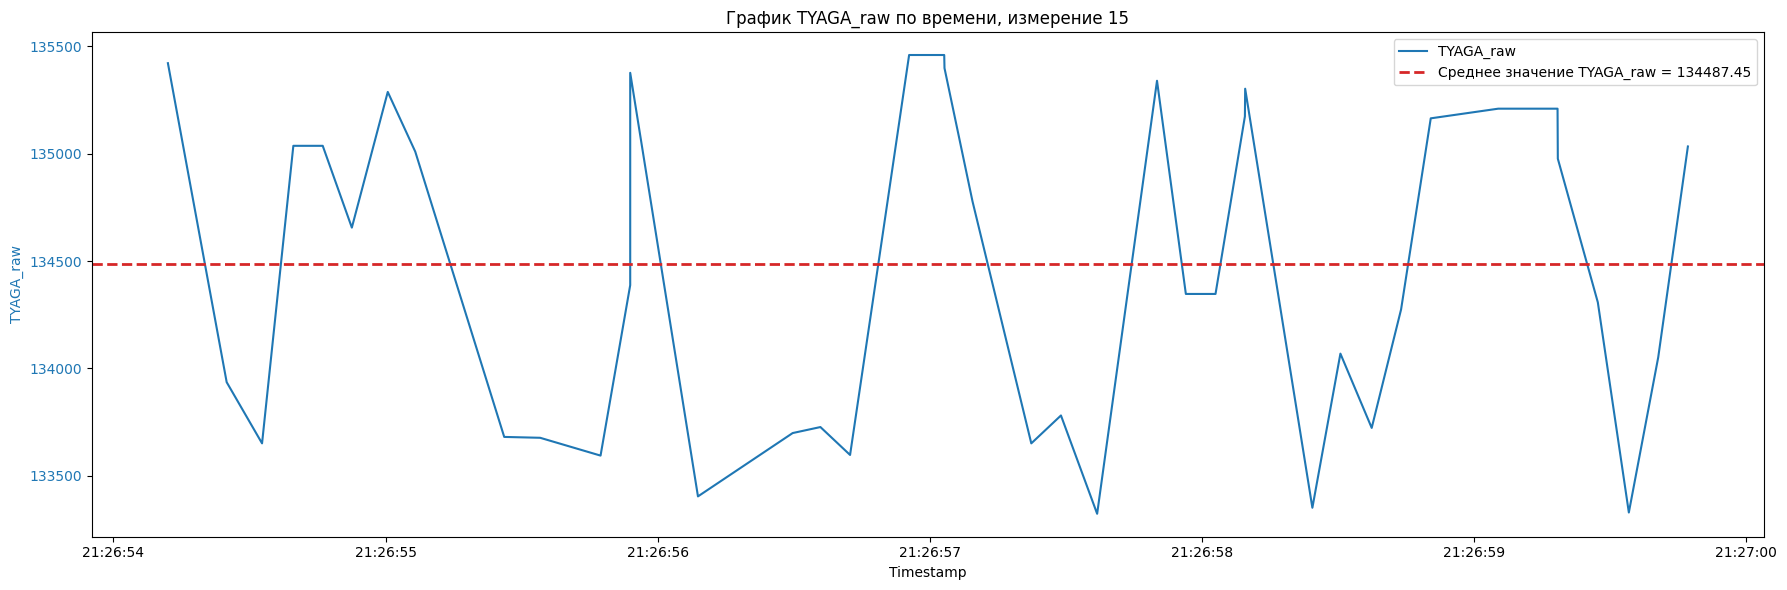

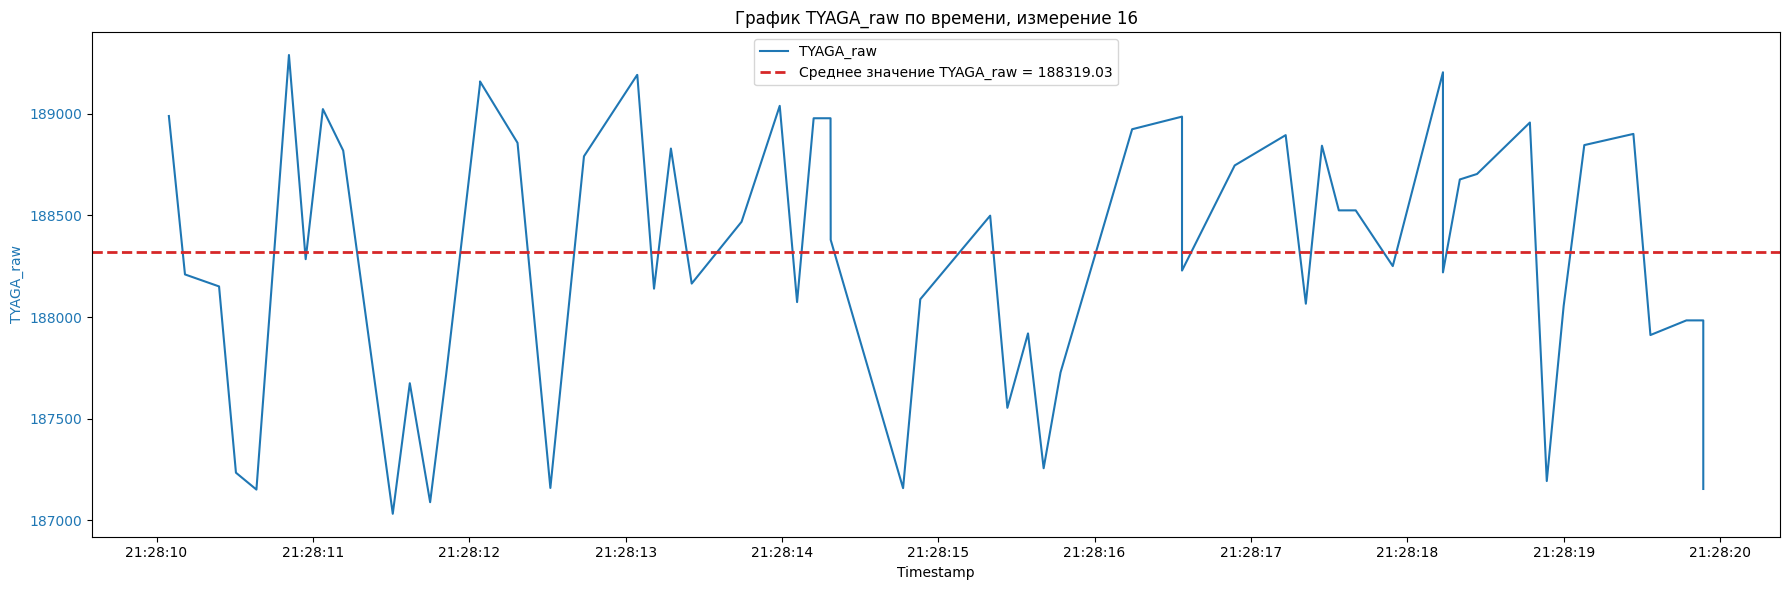

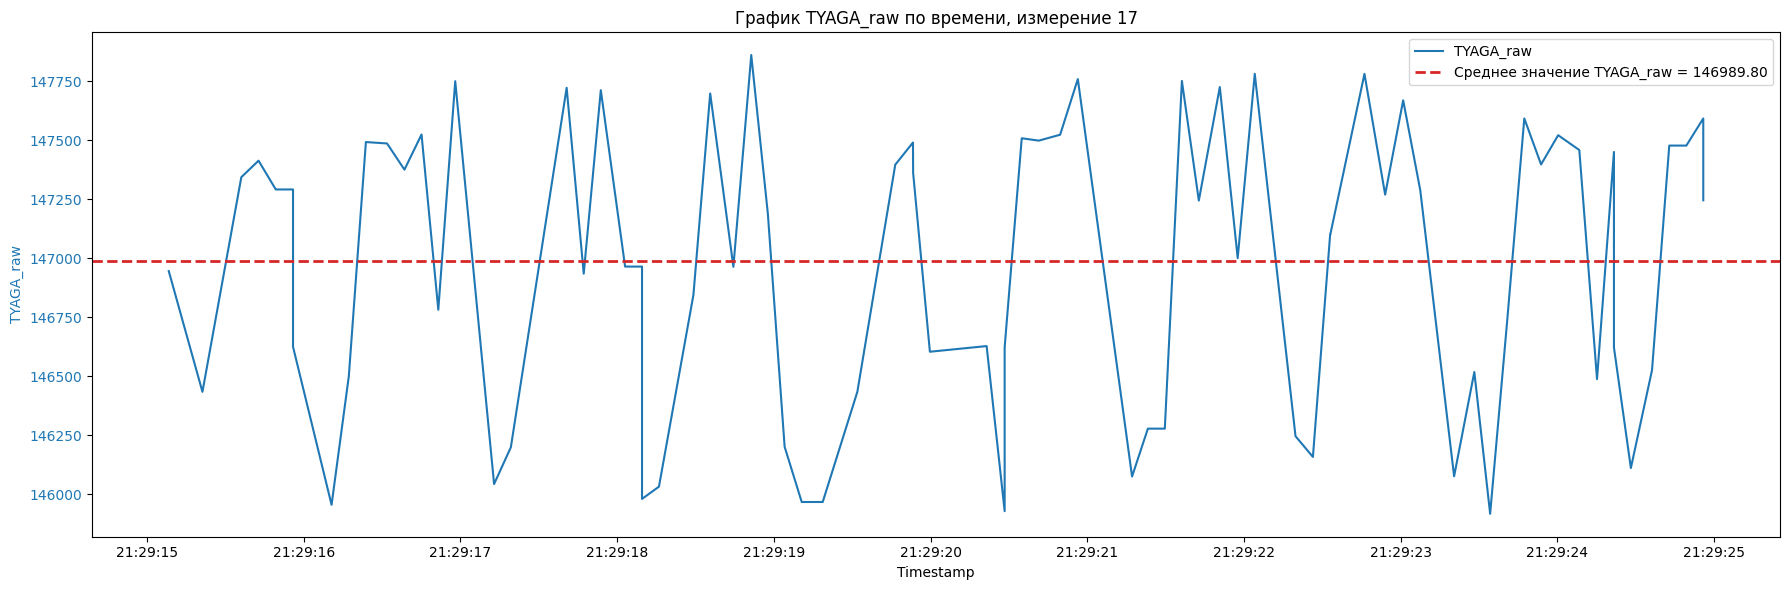

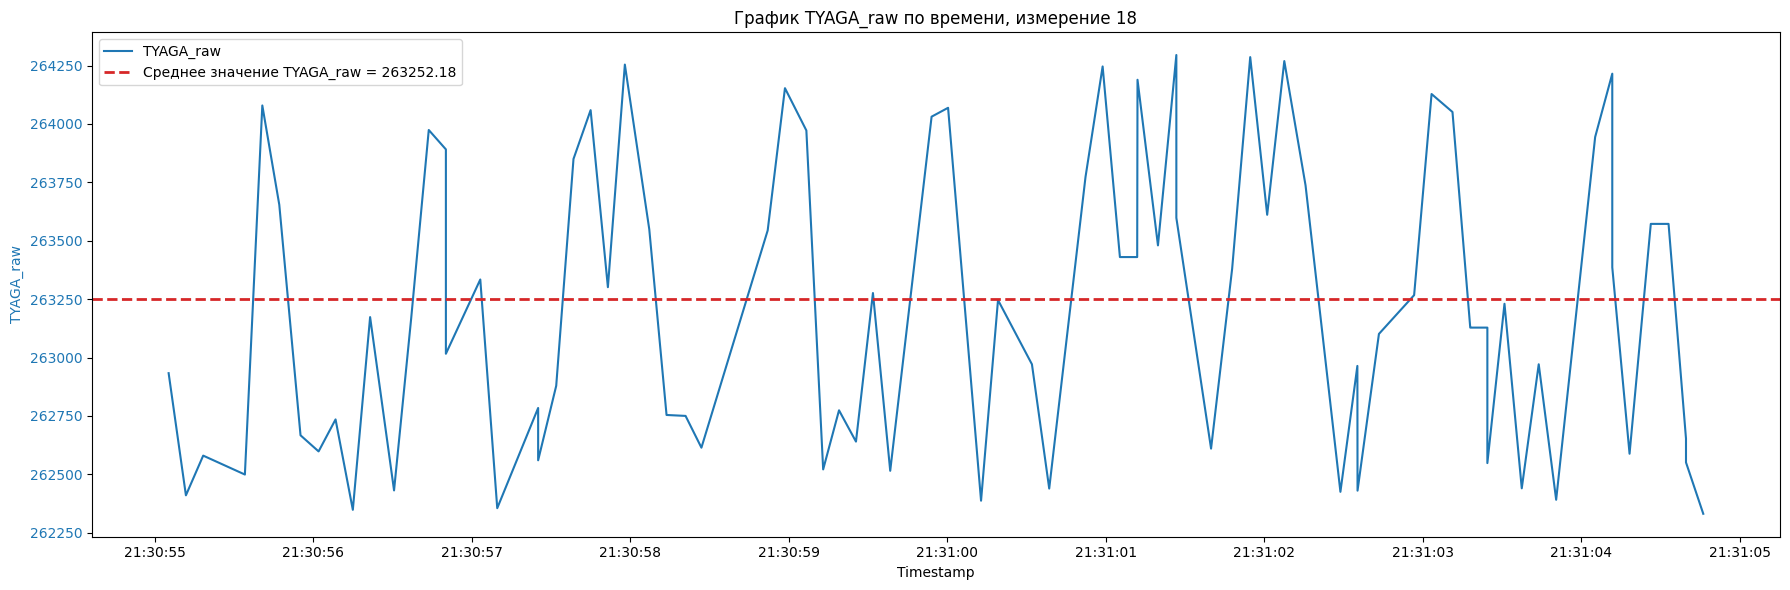

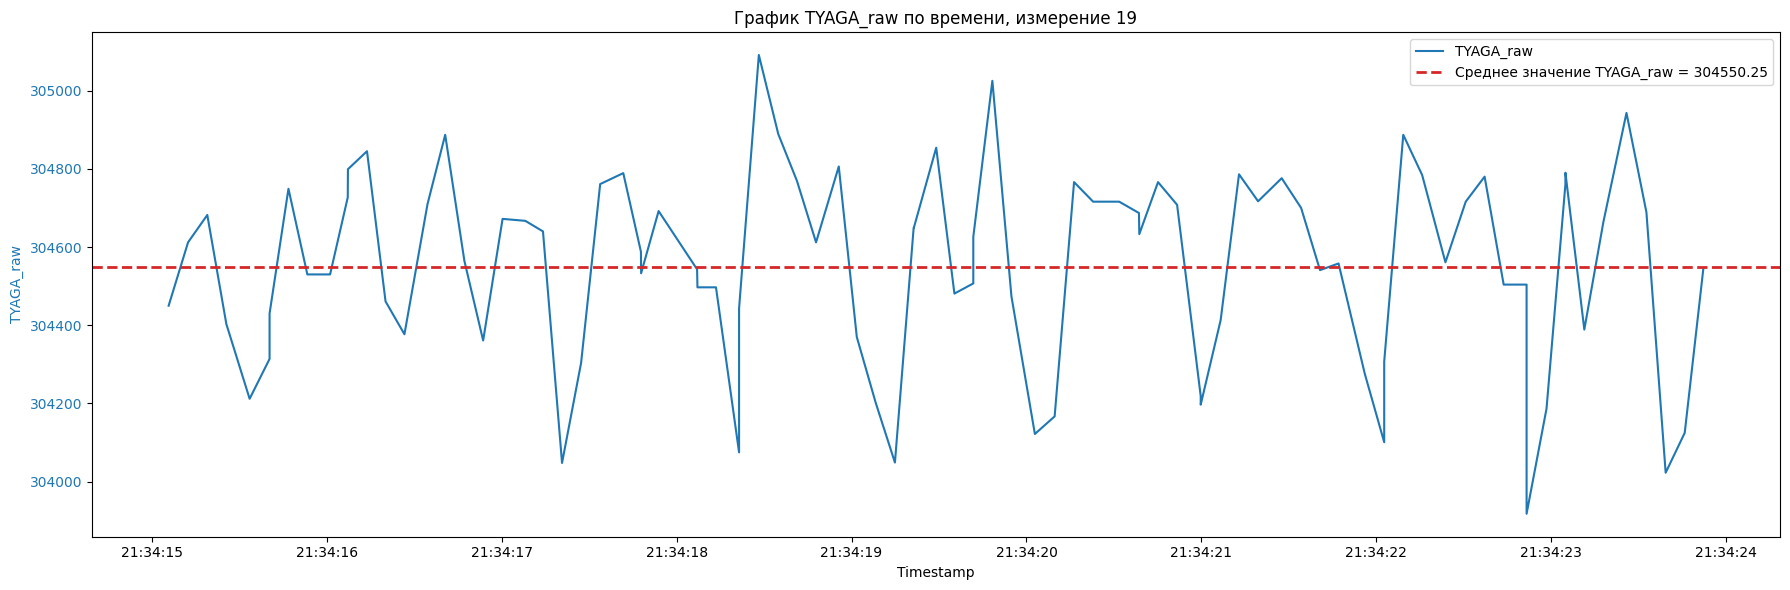

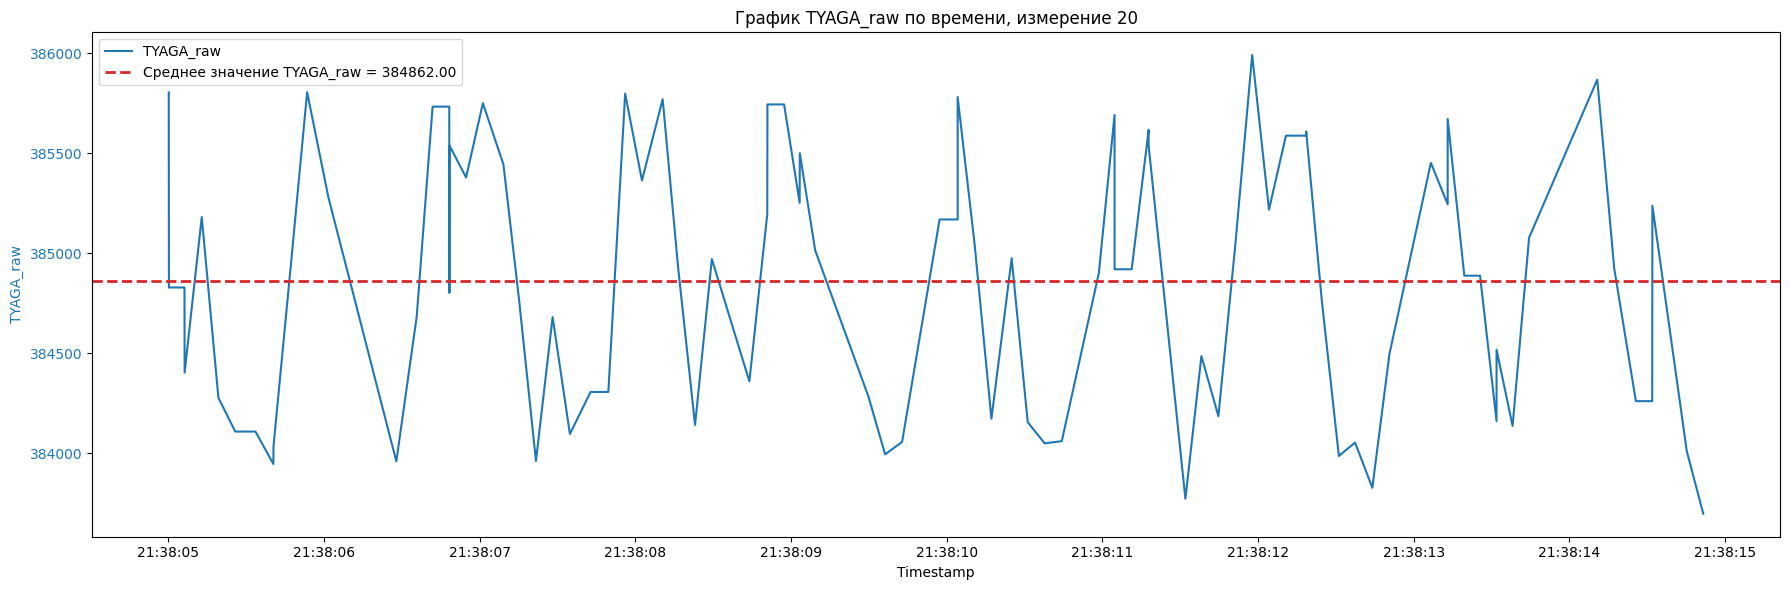

In [82]:
for i in range(1,21):
    start_time = exp5_weight_df.loc[exp5_weight_df['measurement'] == i, 'start_time'][i-1]
    end_time = exp5_weight_df.loc[exp5_weight_df['measurement'] == i, 'end_time'][i-1]
    df = exp5_all_filtered[(exp5_all_filtered['Timestamp'] >= start_time) & (exp5_all_filtered['Timestamp'] <= end_time)]
    fig_TYAGA(df, i)

Сохраним результаты расчетов

In [83]:
exp5_weight_df.to_excel("./results/exp5_weight_df.xlsx") 

Извлекаем значения колонок

In [84]:
X = exp5_weight_df[['mean_TYAGA_raw']].values.reshape(-1, 1)
y = exp5_weight_df['weight'].values

Создаем объект линейной регрессии

In [85]:
model = LinearRegression()

In [86]:
model.fit(X, y)

LinearRegression()

In [87]:
y_pred = model.predict(X)

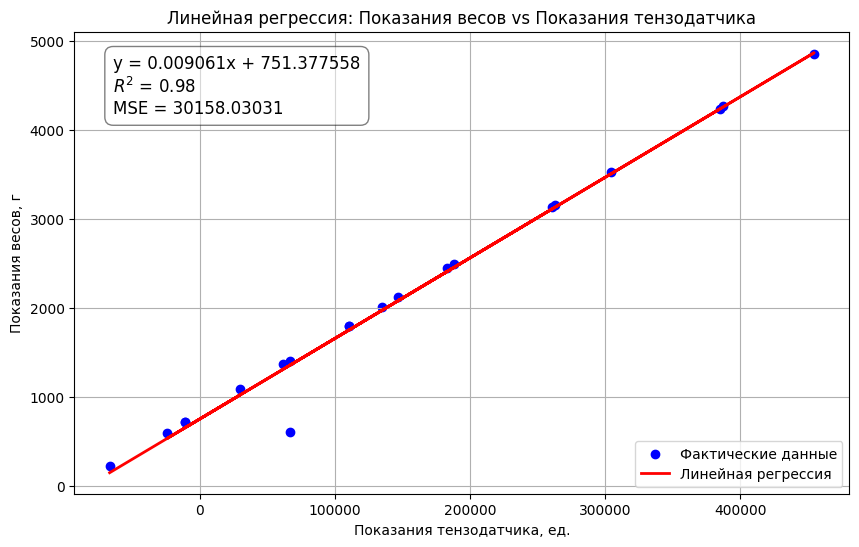

In [88]:
# Вычисляем коэффициенты модели
coef = model.coef_[0]
intercept = model.intercept_

# Вычисляем метрики
r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)

# Рисуем график
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='Фактические данные')
plt.plot(X, y_pred, color='red', linewidth=2, label='Линейная регрессия')
plt.xlabel('Показания тензодатчика, ед.')
plt.ylabel('Показания весов, г')
plt.title('Линейная регрессия: Показания весов vs Показания тензодатчика')

# Добавляем уравнение прямой и метрики на график
equation_text = f'y = {coef:.6f}x + {intercept:.6f}\n$R^2$ = {r2:.2f}\nMSE = {mse:.5f}'
plt.text(0.05, 0.95, equation_text, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.5))

plt.legend()
plt.grid(True)
plt.savefig(f'./results/fig/lintar_regression.png')
plt.show()

Выводим коэффициенты модели в консоль

In [89]:
print(f"a: {coef}")
print(f"b: {intercept}")
print(f"R²: {r2}")
print(f"MSE: {mse}")

a: 0.009060548021582522
b: 751.3775583397914
R²: 0.9829962164648268
MSE: 30158.03031214766


In [90]:
exp5_weight_df['predict'] = exp5_weight_df['mean_TYAGA_raw'].apply(lambda x: x*coef+ intercept)

In [91]:
exp5_weight_df['diff'] = exp5_weight_df['predict'] - exp5_weight_df['weight']

In [92]:
exp5_weight_df

measurement  weight  mean_TYAGA_raw           start_time  \
0             1     219   -66756.217391  2025-01-16 20:52:30   
1             2     716   -11149.097561  2025-01-16 20:53:20   
2             3    1084    29736.948718  2025-01-16 20:54:05   
3             4     599   -24275.507463  2025-01-16 20:55:05   
4             5    1799   110360.280488  2025-01-16 20:56:41   
5             6    4268   387470.677083  2025-01-16 20:58:50   
6             7    4859   454755.140625  2025-01-16 21:01:50   
7             8     716   -11144.843318  2025-01-16 21:04:20   
8             9    1365    61562.028571  2025-01-16 21:06:00   
9            10    1800   110640.654321  2025-01-16 21:07:22   
10           11    2448   183219.243902  2025-01-16 21:08:30   
11           12    3140   260731.058824  2025-01-16 21:10:40   
12           13    1409    66580.739884  2025-01-16 21:13:10   
13           14     605    66623.011628  2025-01-16 21:15:10   
14           15    2013   134487.454545  2025-01-16 21:26:54   
15           16    2491   188319.032258  2025-01-16 21:28:10   
16           17    2123   146989.797619  2025-01-16 21:29:15   
17           18    3162   263252.181818  2025-01-16 21:30:55   
18           19    3528   304550.250000  2025-01-16 21:34:15   
19           20    4235   384862.000000  2025-01-16 21:38:05   

               end_time      predict        diff  
0   2025-01-16 20:52:38   146.529645  -72.470355  
1   2025-01-16 20:53:30   650.360624  -65.639376  
2   2025-01-16 20:54:17  1020.810610  -63.189390  
3   2025-01-16 20:55:14   531.428157  -67.571843  
4   2025-01-16 20:56:51  1751.302179  -47.697821  
5   2025-01-16 20:59:15  4262.074235   -5.925765  
6   2025-01-16 21:02:00  4871.708348   12.708348  
7   2025-01-16 21:04:45   650.399170  -65.600830  
8   2025-01-16 21:06:10  1309.163275  -55.836725  
9   2025-01-16 21:07:32  1753.842520  -46.157480  
10  2025-01-16 21:08:40  2411.444316  -36.555684  
11  2025-01-16 21:11:00  3113.743838  -26.256162  
12  2025-01-16 21:13:30  1354.635549  -54.364451  
13  2025-01-16 21:15:30  1355.018555  750.018555  
14  2025-01-16 21:27:00  1969.907599  -43.092401  
15  2025-01-16 21:28:20  2457.651193  -33.348807  
16  2025-01-16 21:29:25  2083.185678  -39.814322  
17  2025-01-16 21:31:05  3136.586593  -25.413407  
18  2025-01-16 21:34:24  3510.769723  -17.230277  
19  2025-01-16 21:38:15  4238.438191    3.438191

Из графика линейной регрессии видно, что есть явно выброс в значениях, удалим его, найдя как больше всего отличающийся от расчетных

In [93]:
# Индекс строки с максимальным по модулю значением в столбце diff
max_diff_index = exp5_weight_df['diff'].abs().idxmax()

# Удалим строку с этим индексом
exp5_weight_df = exp5_weight_df.drop(index=max_diff_index)

# Сбросим индексы для удобства
exp5_weight_df = exp5_weight_df.reset_index(drop=True)


Еще раз найдетм уравнение регрессии

Извлекаем значения колонок

In [94]:
X = exp5_weight_df[['mean_TYAGA_raw']].values.reshape(-1, 1)
y = exp5_weight_df['weight'].values

Создаем объект линейной регрессии

In [95]:
model = LinearRegression()

In [96]:
model.fit(X, y)

LinearRegression()

In [97]:
y_pred = model.predict(X)

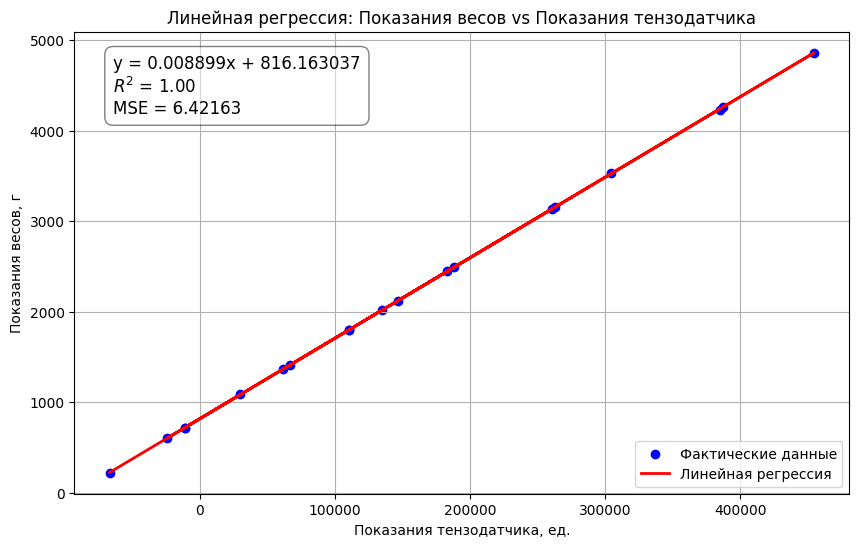

In [98]:
# Вычисляем коэффициенты модели
coef = model.coef_[0]
intercept = model.intercept_

# Вычисляем метрики
r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)

# Рисуем график
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='Фактические данные')
plt.plot(X, y_pred, color='red', linewidth=2, label='Линейная регрессия')
plt.xlabel('Показания тензодатчика, ед.')
plt.ylabel('Показания весов, г')
plt.title('Линейная регрессия: Показания весов vs Показания тензодатчика')

# Добавляем уравнение прямой и метрики на график
equation_text = f'y = {coef:.6f}x + {intercept:.6f}\n$R^2$ = {r2:.2f}\nMSE = {mse:.5f}'
plt.text(0.05, 0.95, equation_text, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.5))

plt.legend()
plt.grid(True)
plt.savefig(f'./results/fig/lintar_regression.png')
plt.show()

Выводим коэффициенты модели

In [99]:
print(f"a: {coef}")
print(f"b: {intercept}")
print(f"R²: {r2}")
print(f"MSE: {mse}")

a: 0.008898855172856324
b: 816.163037447357
R²: 0.9999963057743096
MSE: 6.421630622275167


Коэффициенты линейной регрессии можно считать точными. Было выполнено 20 измерений, одно из которых было удалено из расчетов, при этом значение R²=1, что соответсвет линейной зависимости.